## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.). 



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost. 
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [1]:
# To help with reading and manipulating data
import pandas as pd
import numpy as np
import sklearn
# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

# This will help in making the Python code more structured automatically (good coding practice)
#%load_ext nb_black

## Loading the dataset

In [3]:
df_train = pd.read_csv("Train.csv")
df_test = pd.read_csv("Test.csv")

In [4]:
df_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


In [5]:
df_train.shape

(20000, 41)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

The dataset contains 40 sensor datapoints for each row, with 20,000 rows of data. v1 and v2 have missing values.

In [7]:
df_train.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
V1,19982.000,-0.272,3.442,-11.876,-2.737,-0.748,1.840,15.493
V2,19982.000,0.440,3.151,-12.320,-1.641,0.472,2.544,13.089
V3,20000.000,2.485,3.389,-10.708,0.207,2.256,4.566,17.091
V4,20000.000,-0.083,3.432,-15.082,-2.348,-0.135,2.131,13.236
V5,20000.000,-0.054,2.105,-8.603,-1.536,-0.102,1.340,8.134
V6,20000.000,-0.995,2.041,-10.227,-2.347,-1.001,0.380,6.976
V7,20000.000,-0.879,1.762,-7.950,-2.031,-0.917,0.224,8.006
V8,20000.000,-0.548,3.296,-15.658,-2.643,-0.389,1.723,11.679
V9,20000.000,-0.017,2.161,-8.596,-1.495,-0.068,1.409,8.138
V10,20000.000,-0.013,2.193,-9.854,-1.411,0.101,1.477,8.108


In [8]:
df_train.duplicated().sum()

0

There are no duplicate values in the dataset and no need for feature engineering as all columns are pertinent to the model.

## Data Overview

- Observations
- Sanity checks

## Exploratory Data Analysis (EDA)

### Plotting histograms and boxplots for all the variables

In [9]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Plotting all the features at one go

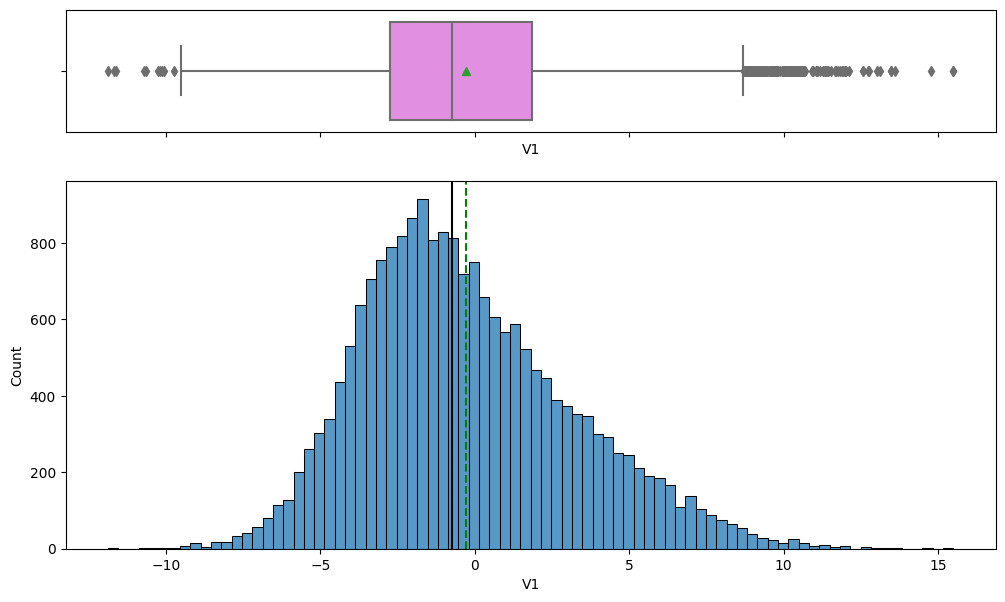

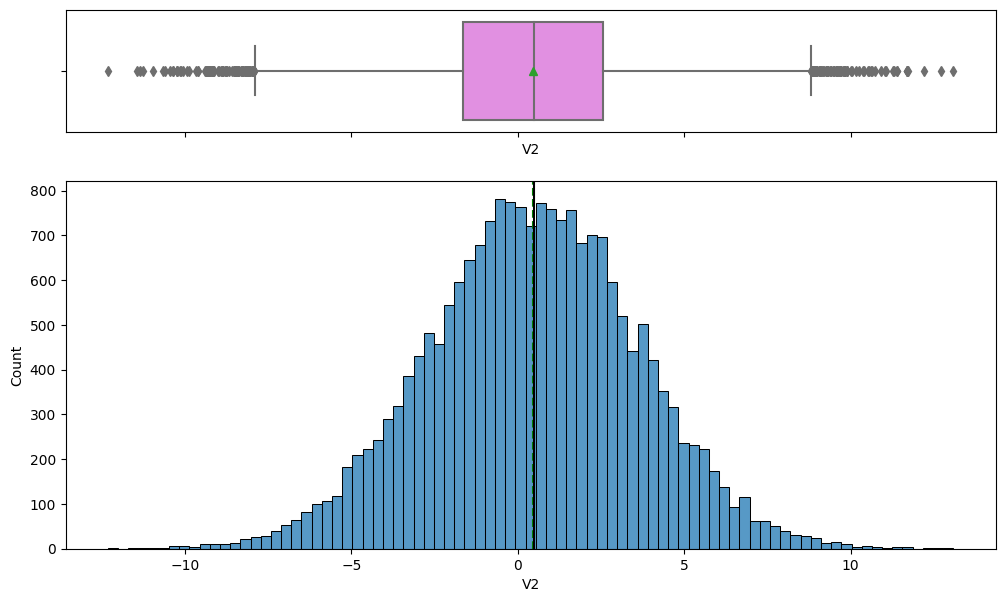

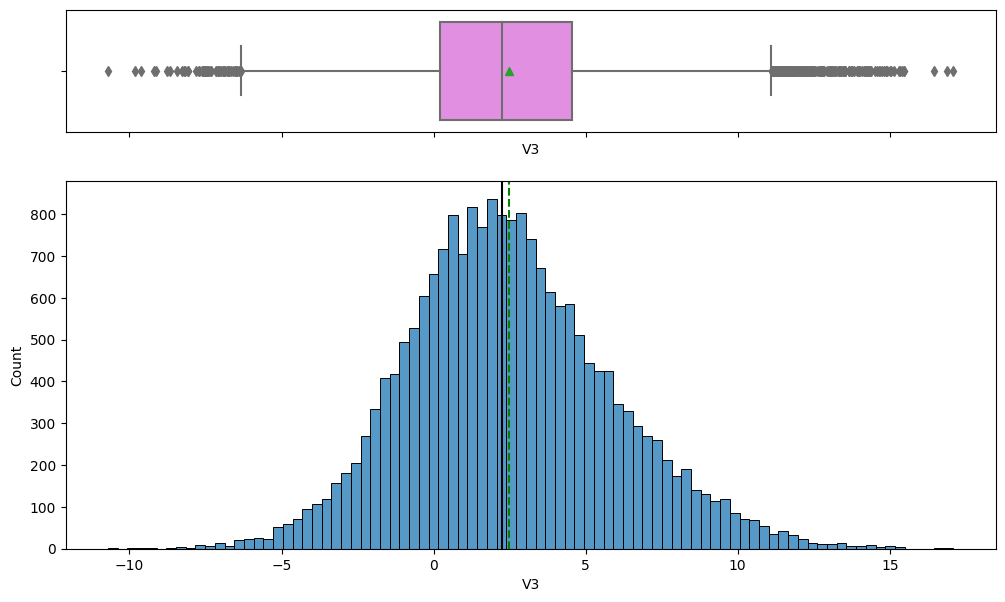

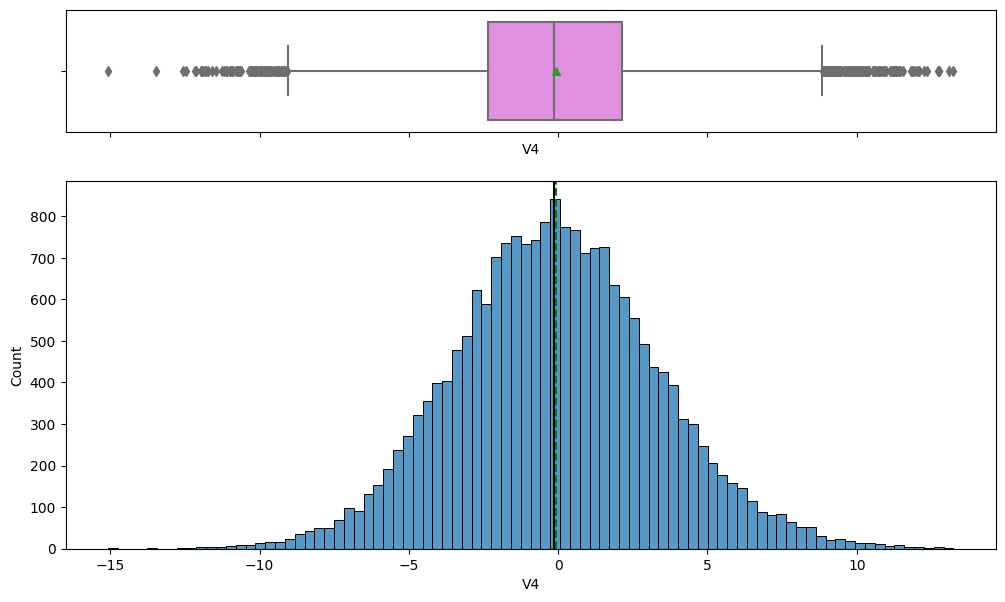

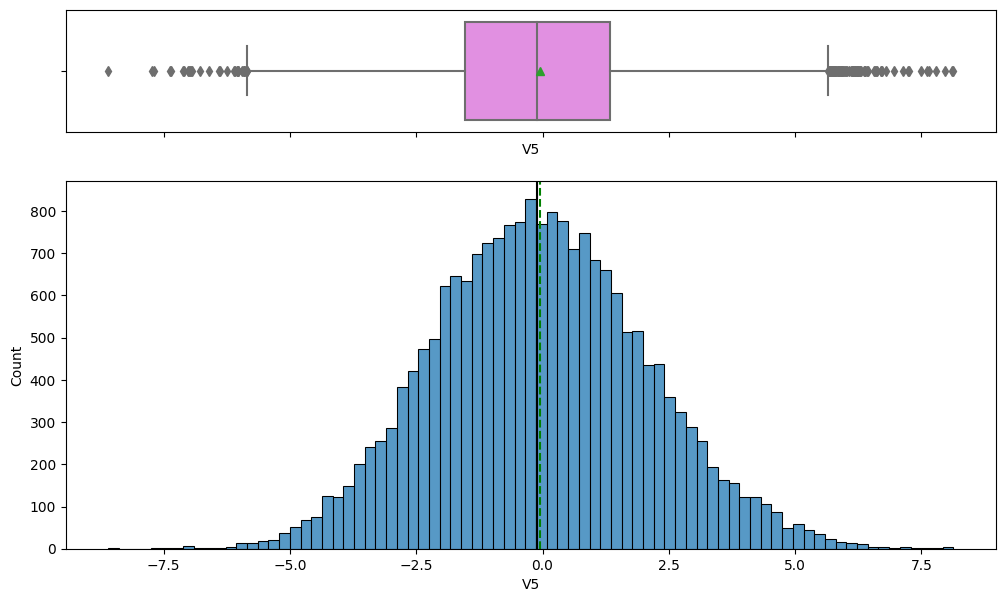

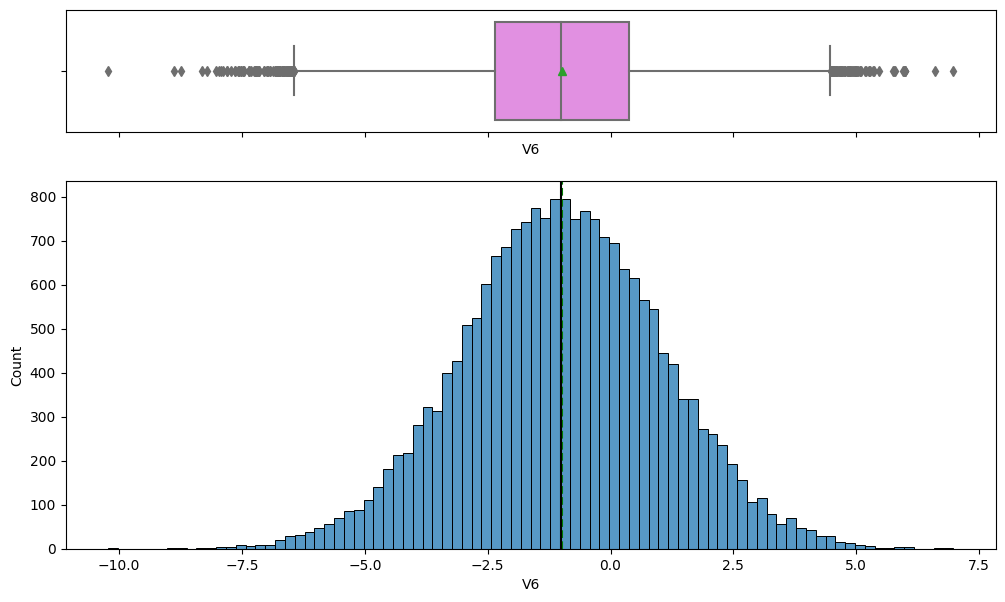

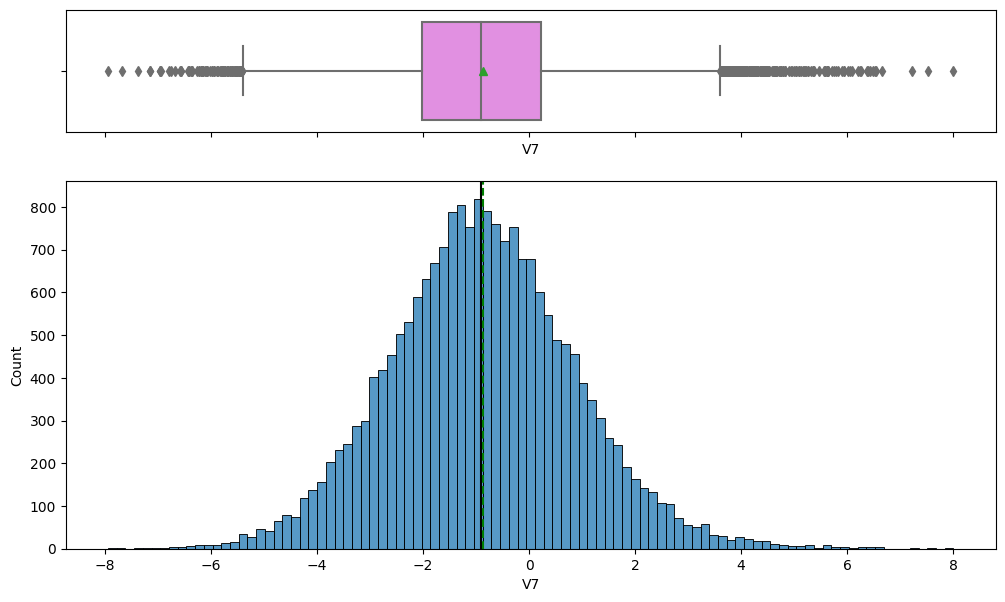

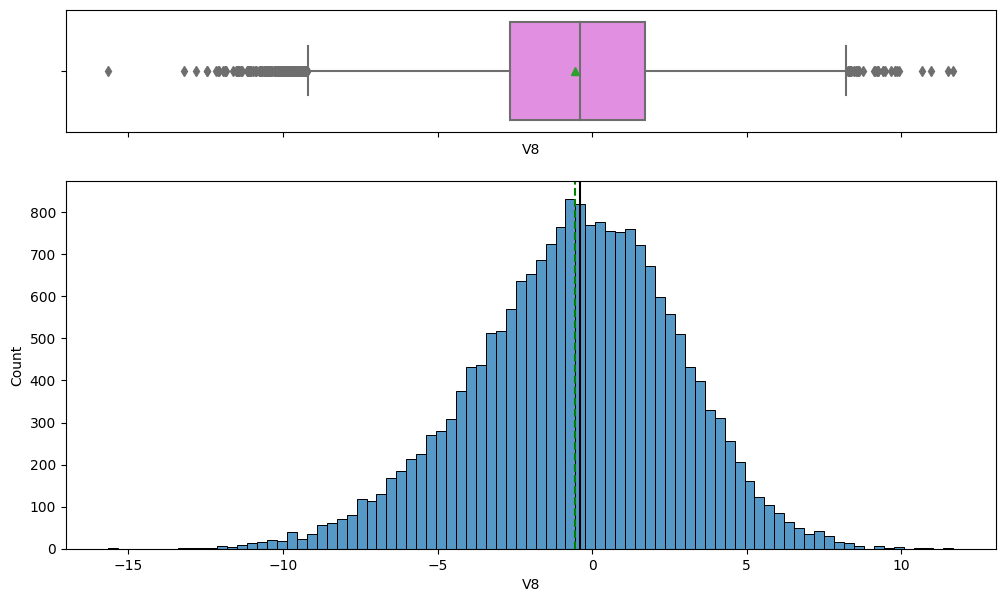

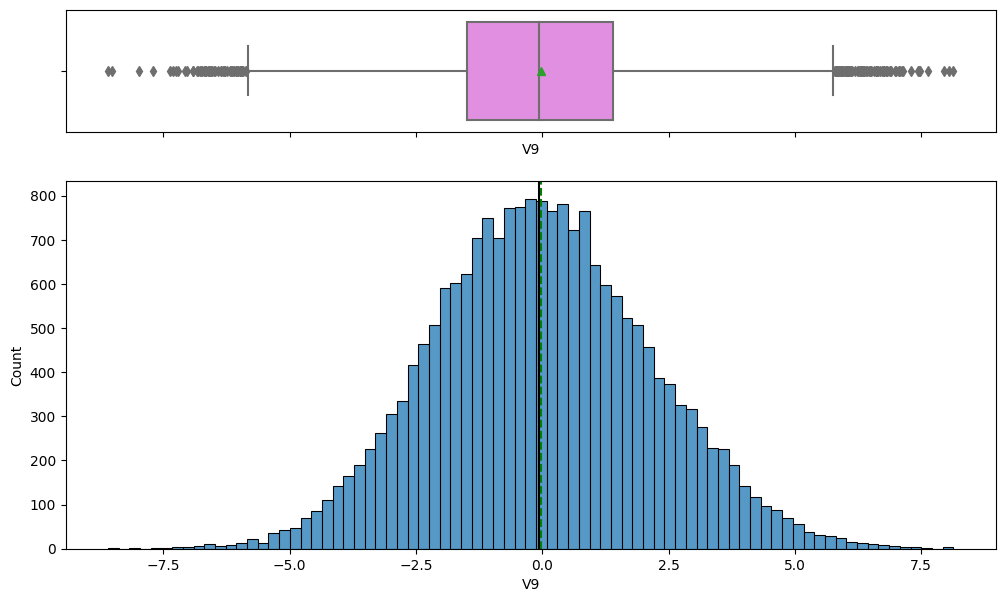

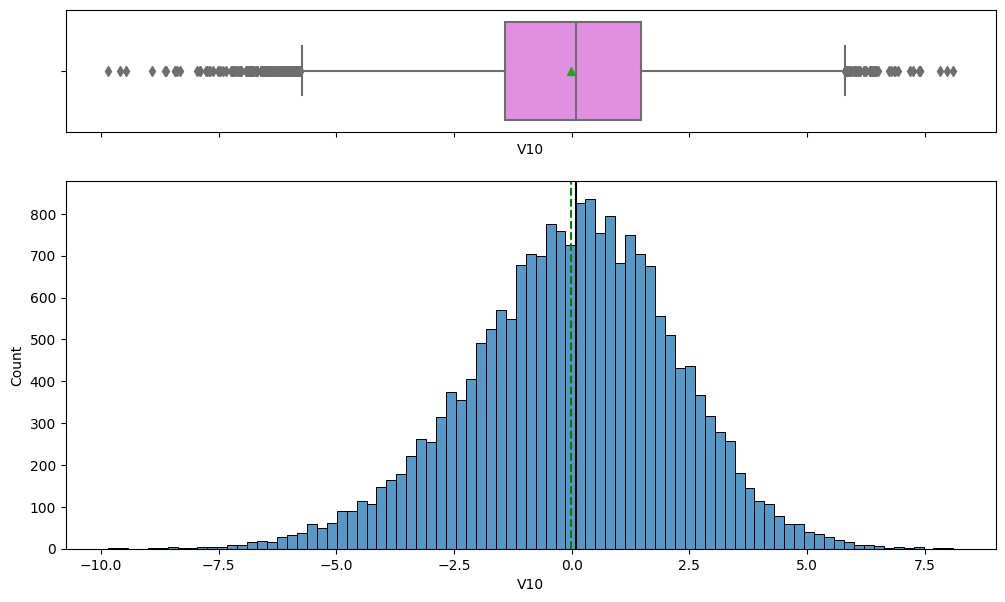

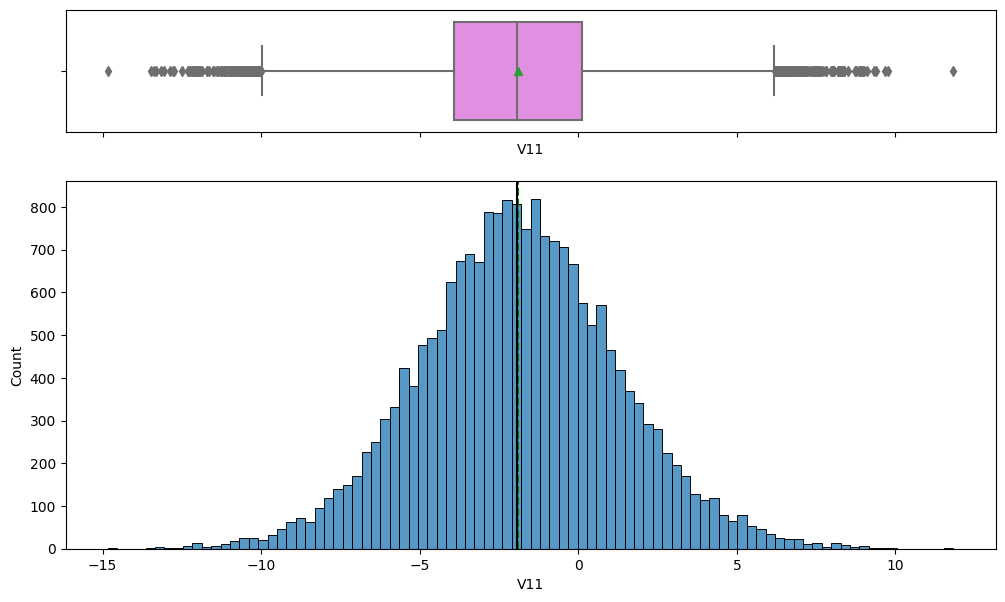

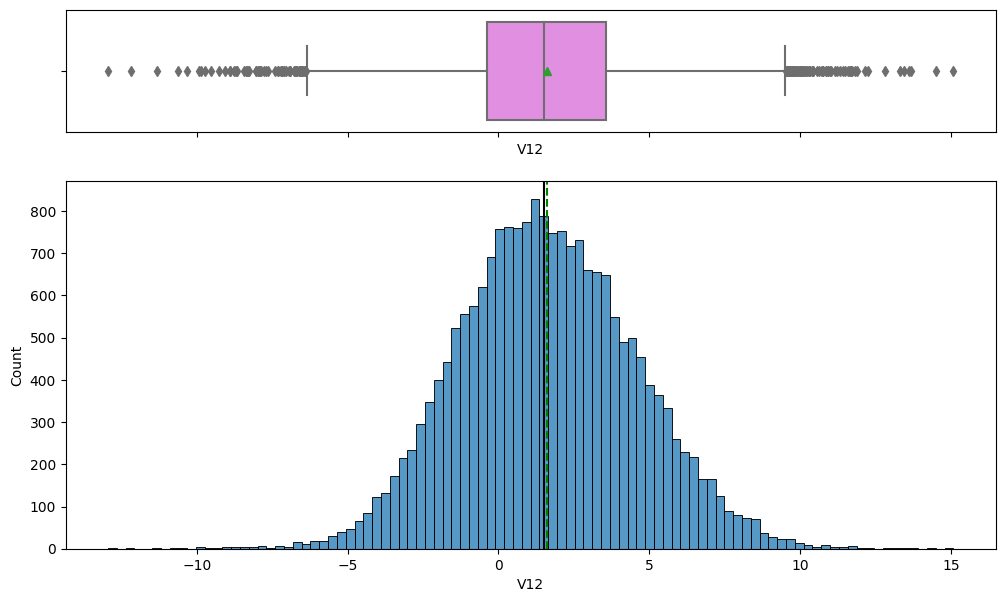

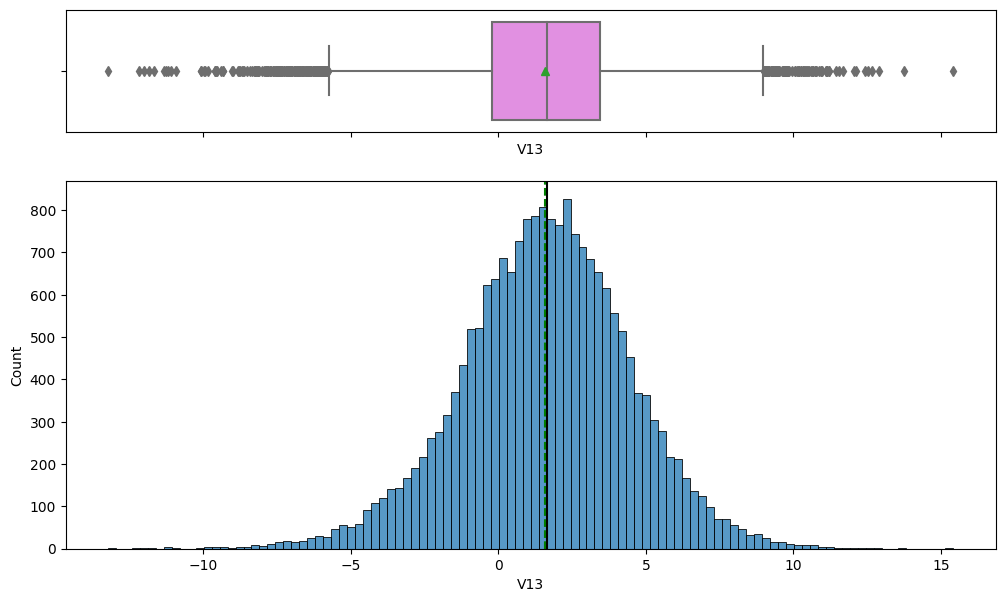

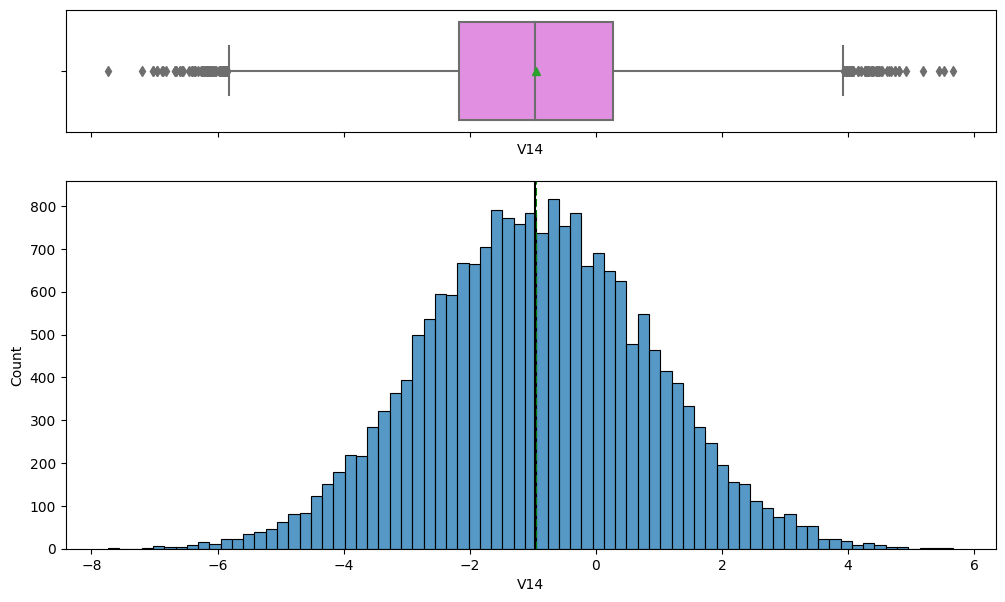

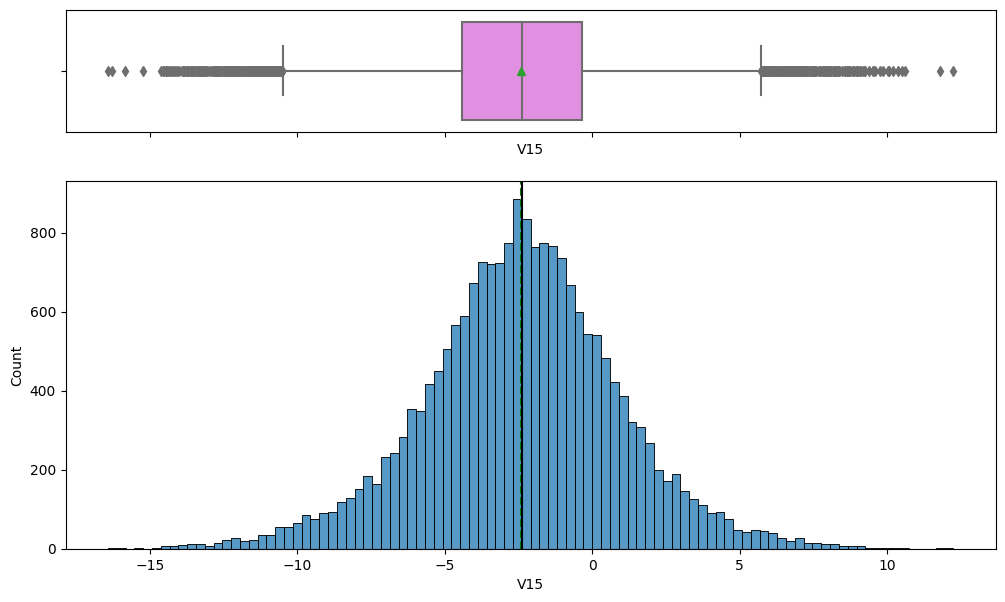

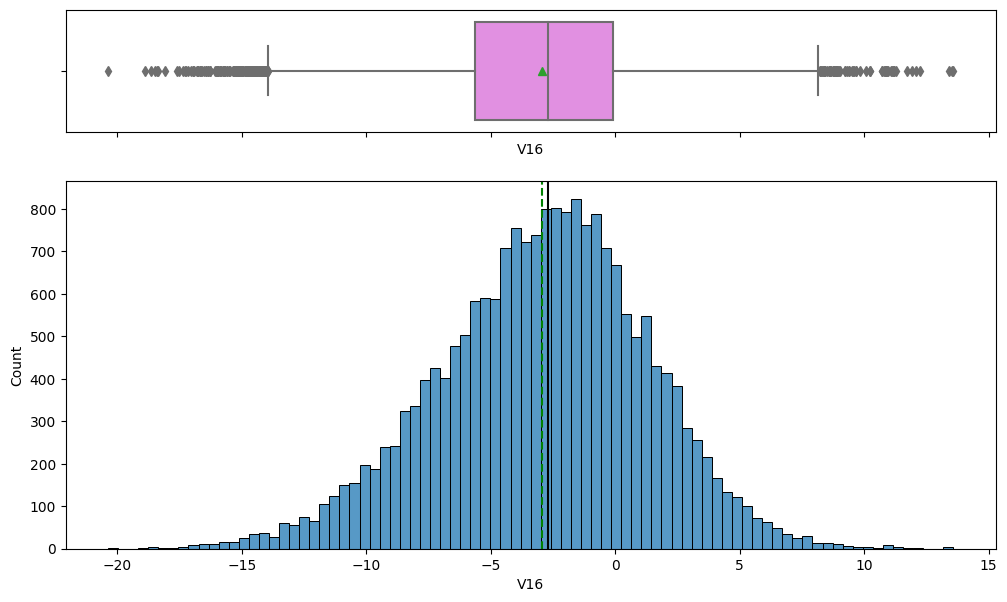

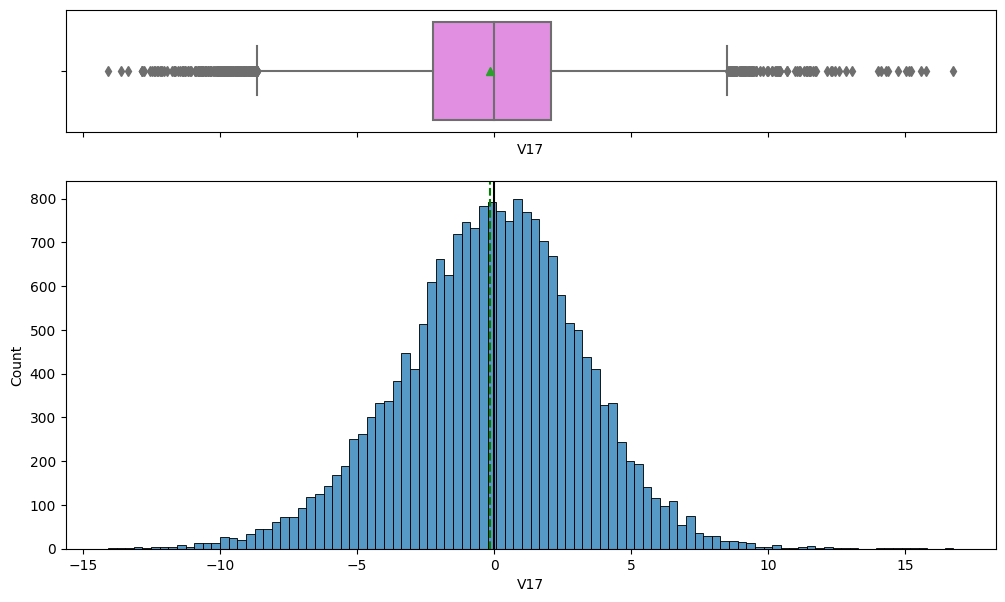

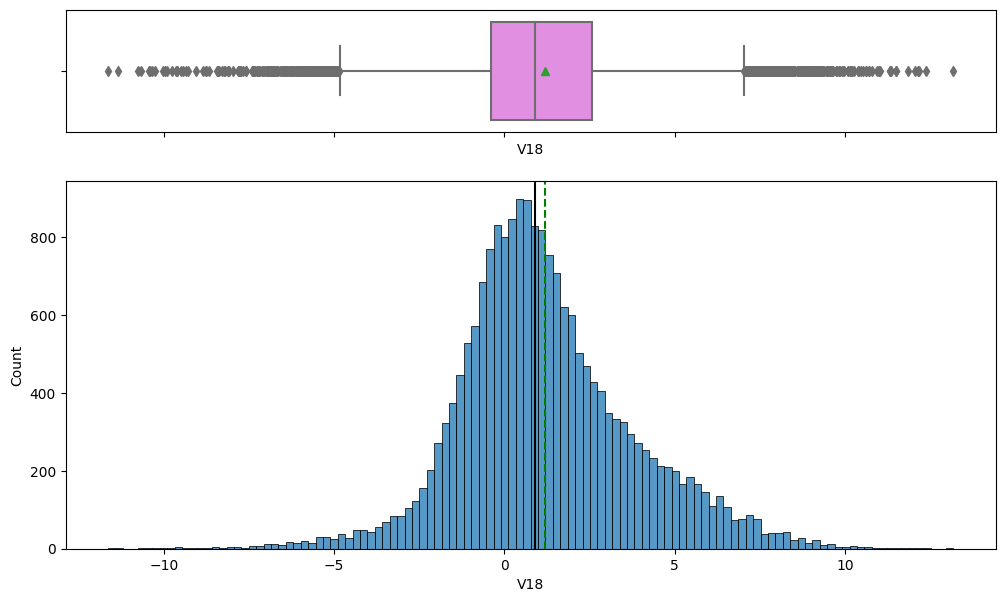

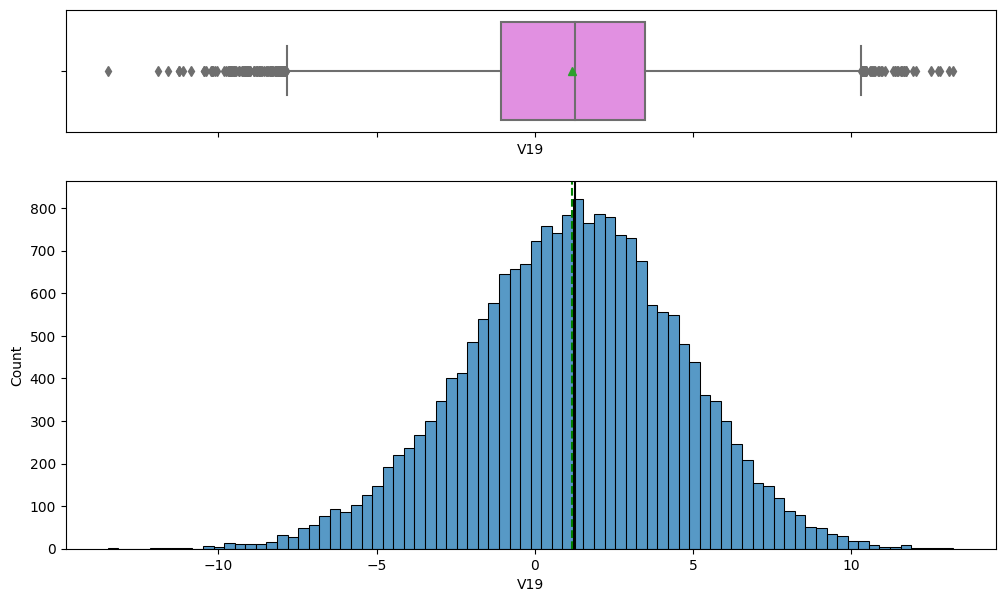

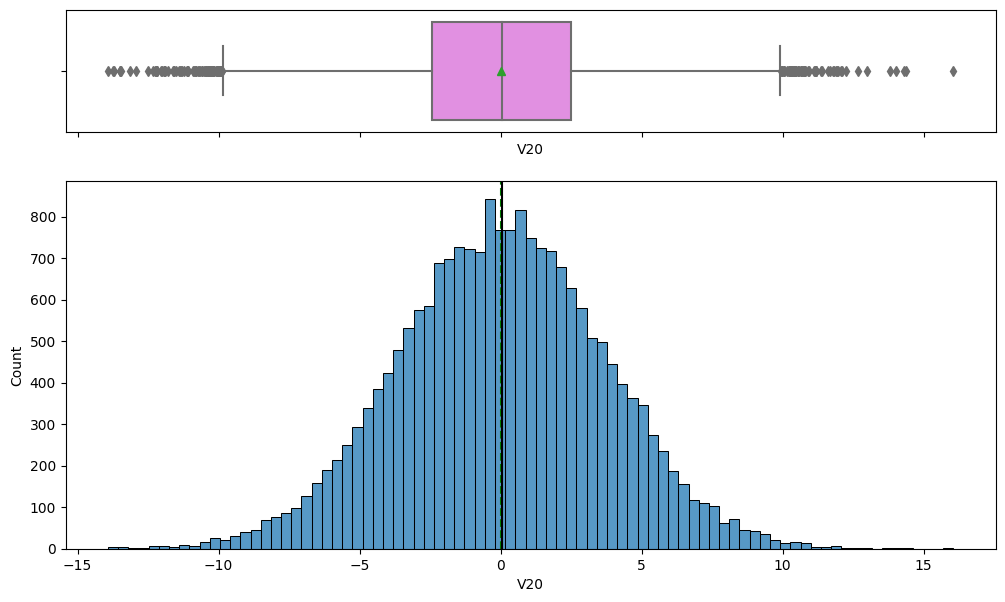

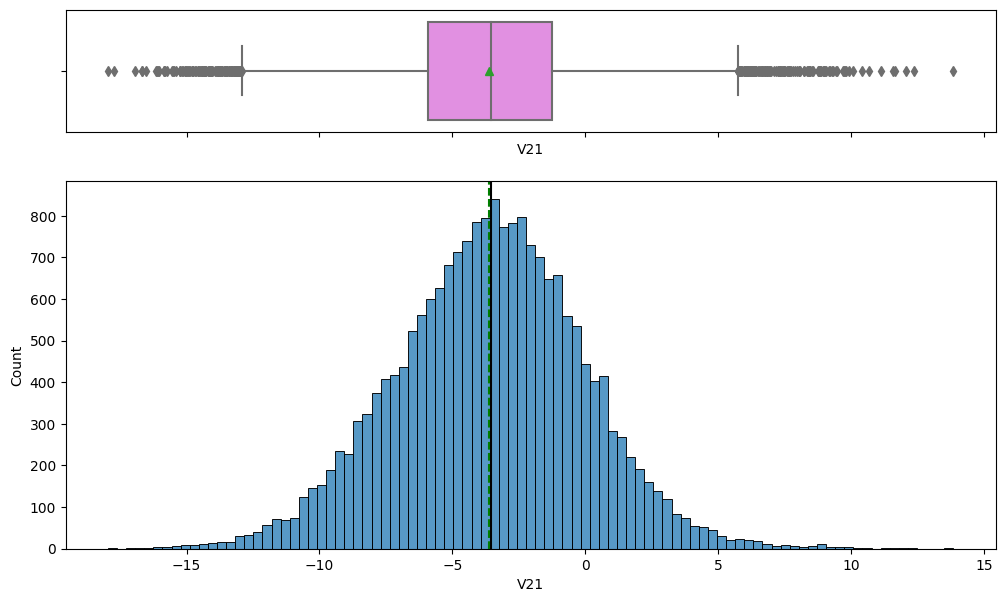

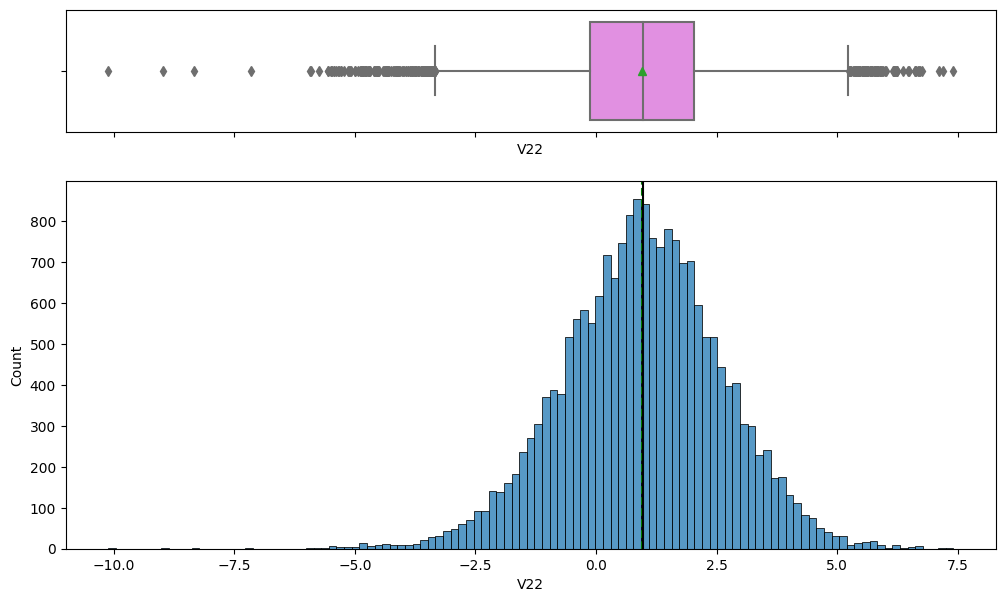

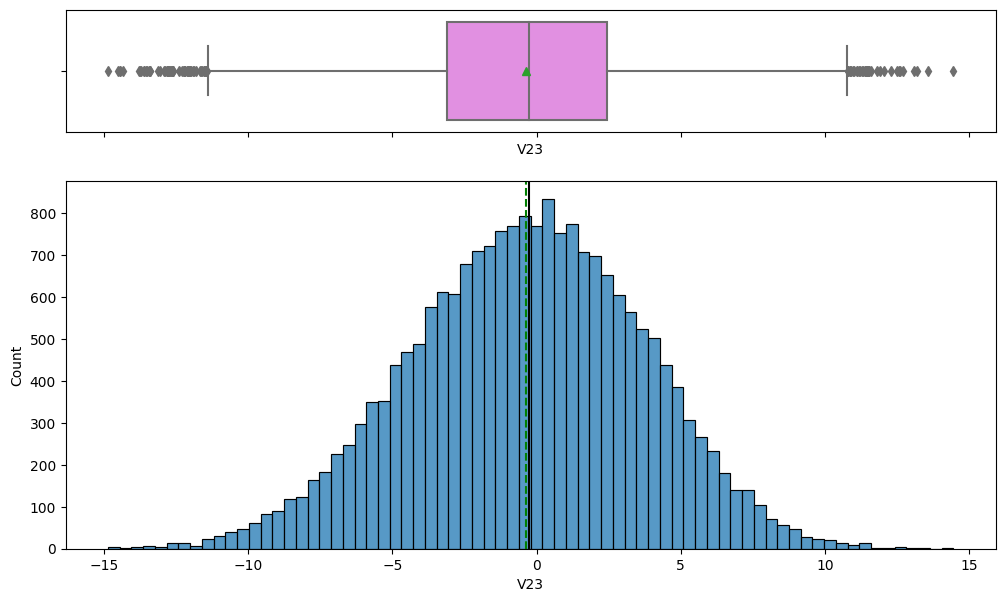

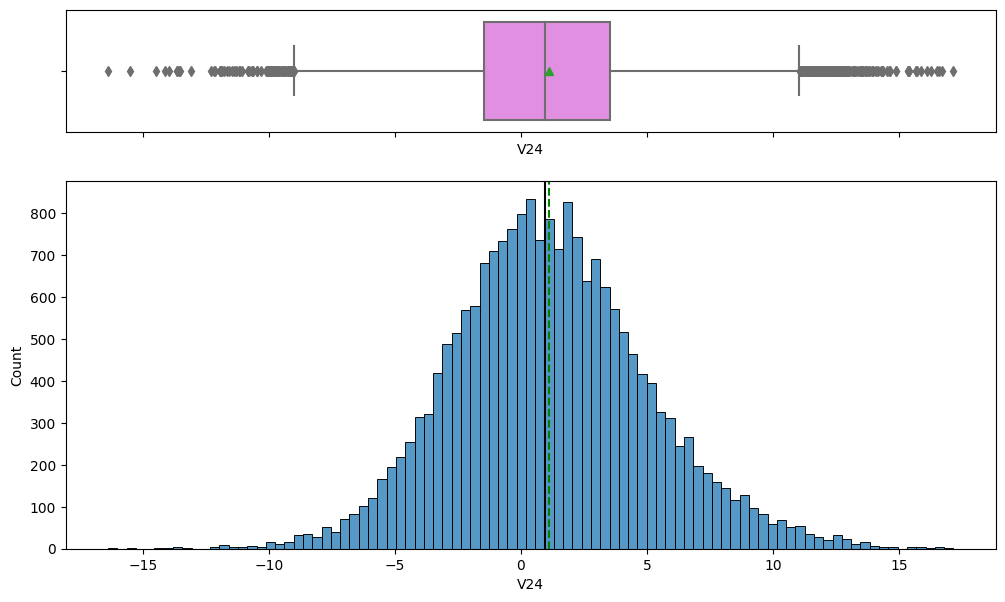

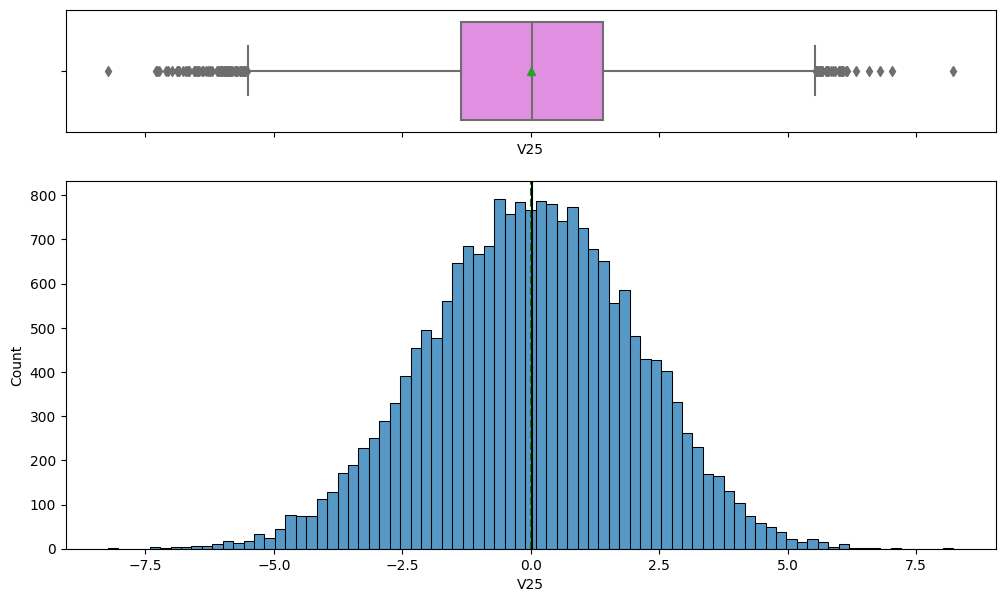

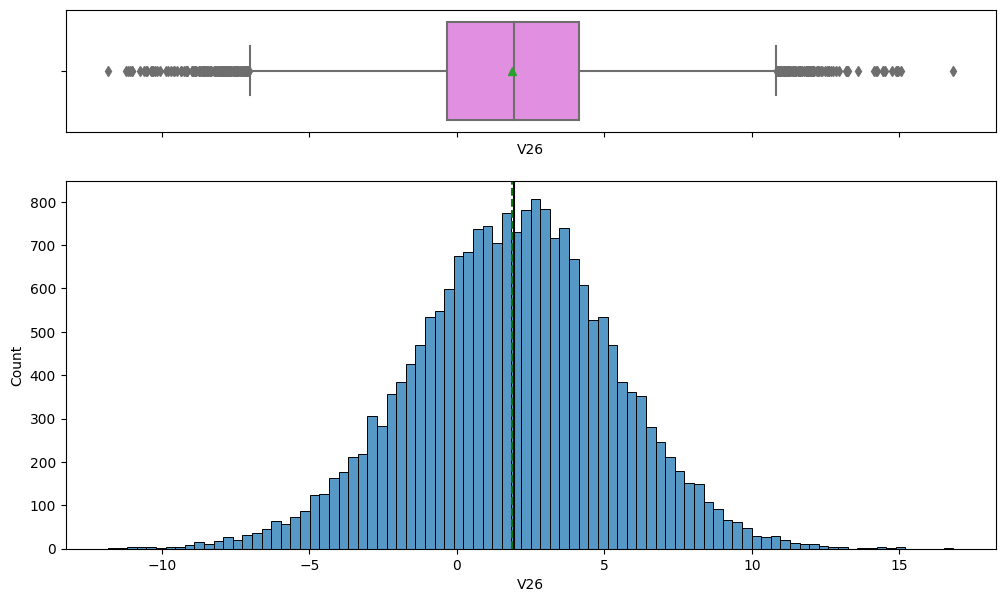

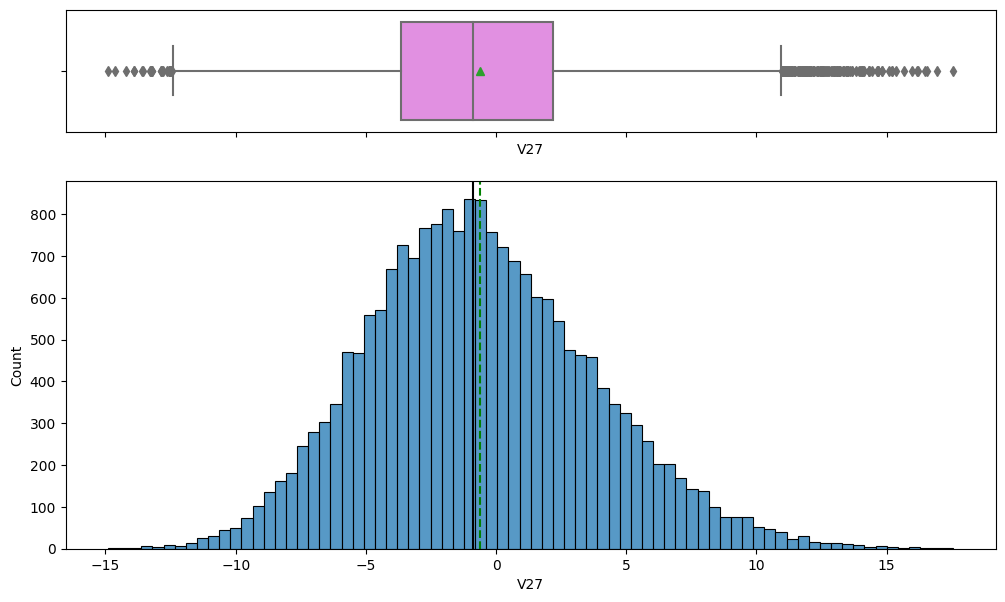

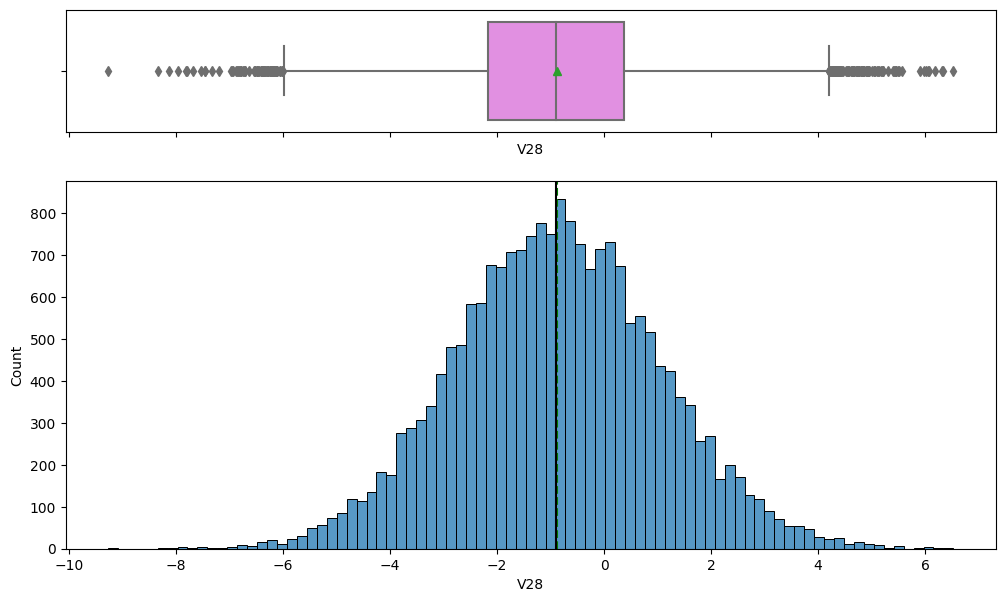

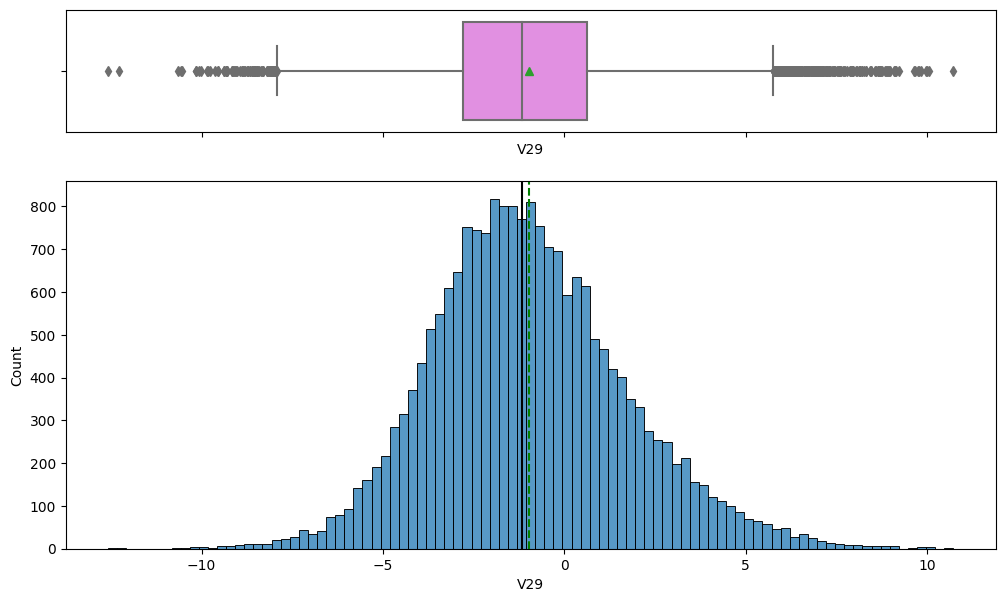

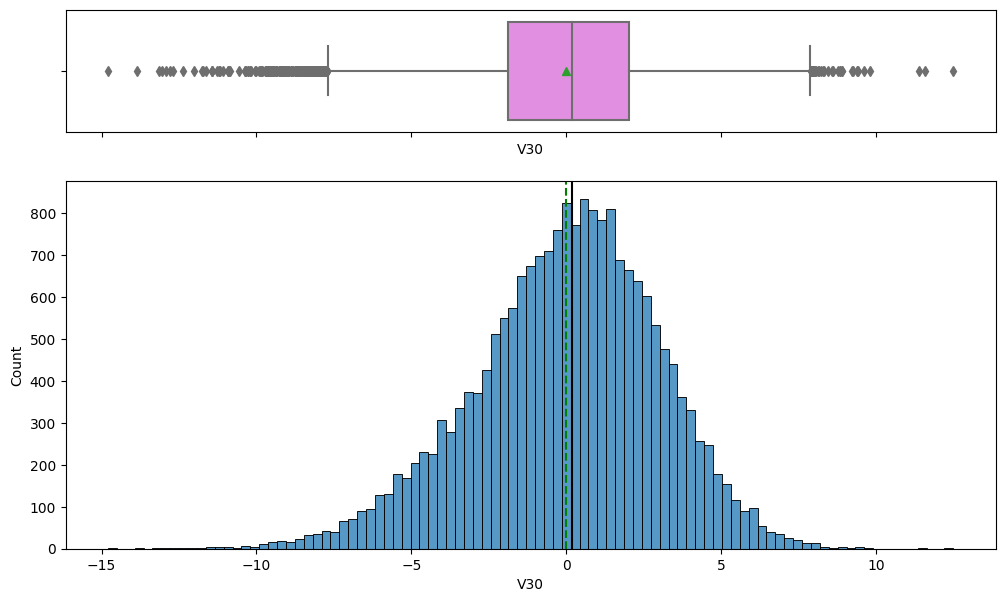

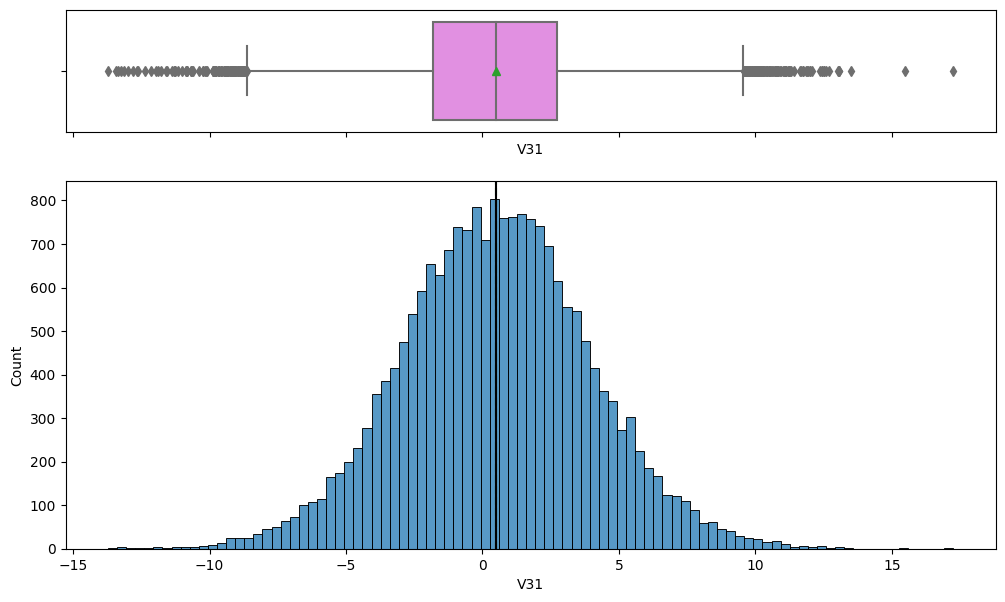

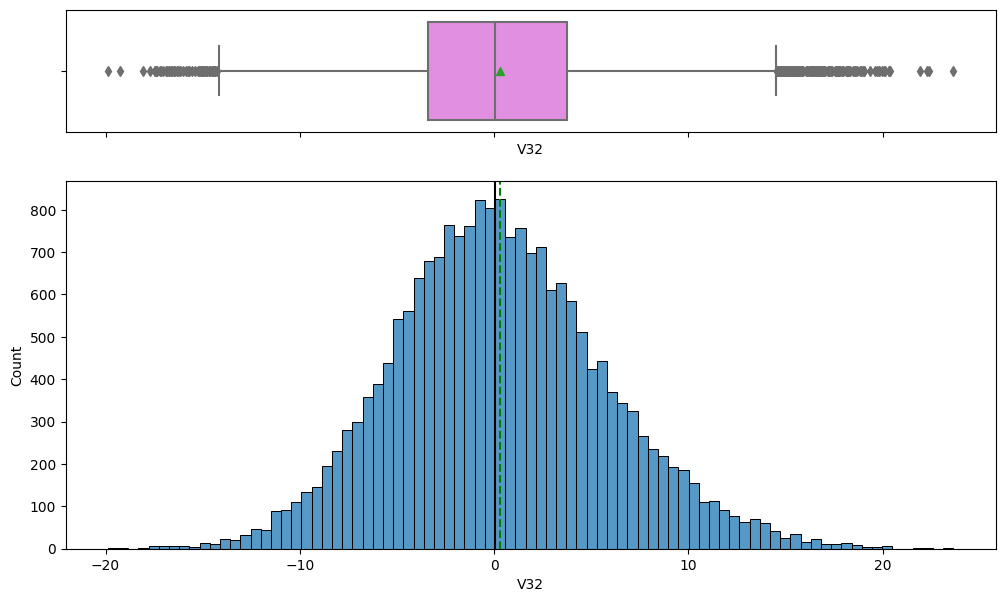

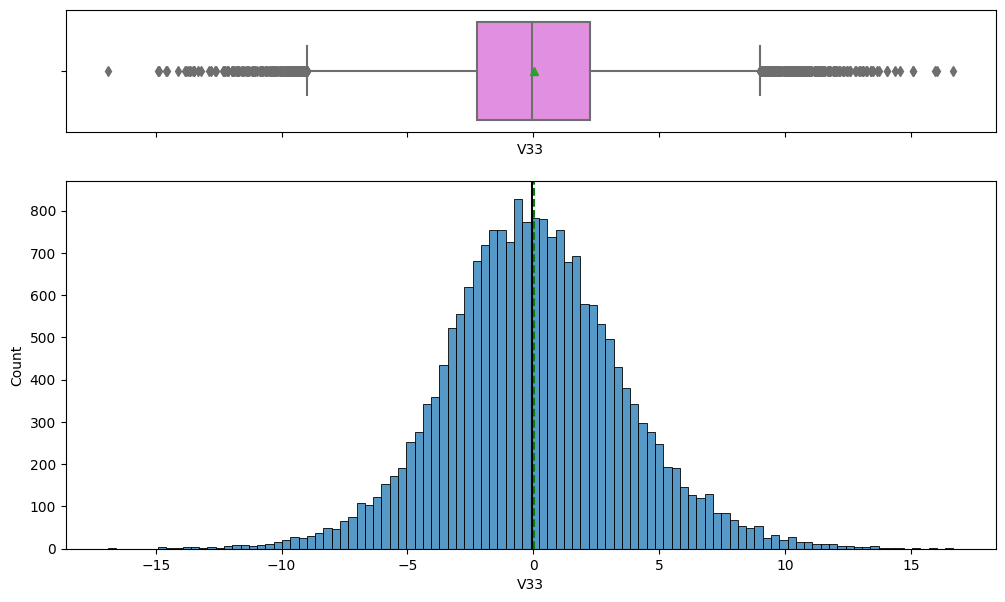

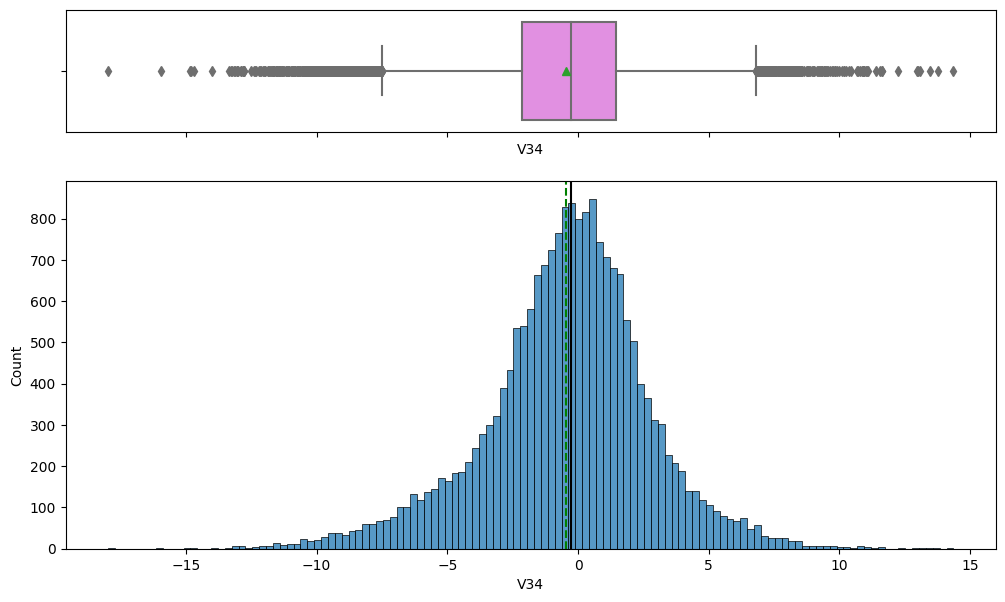

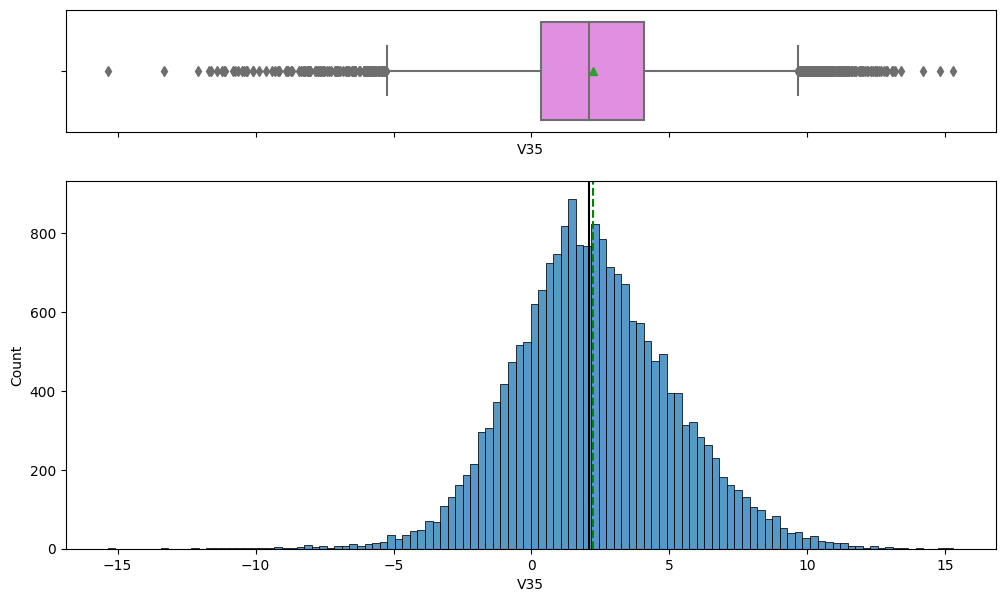

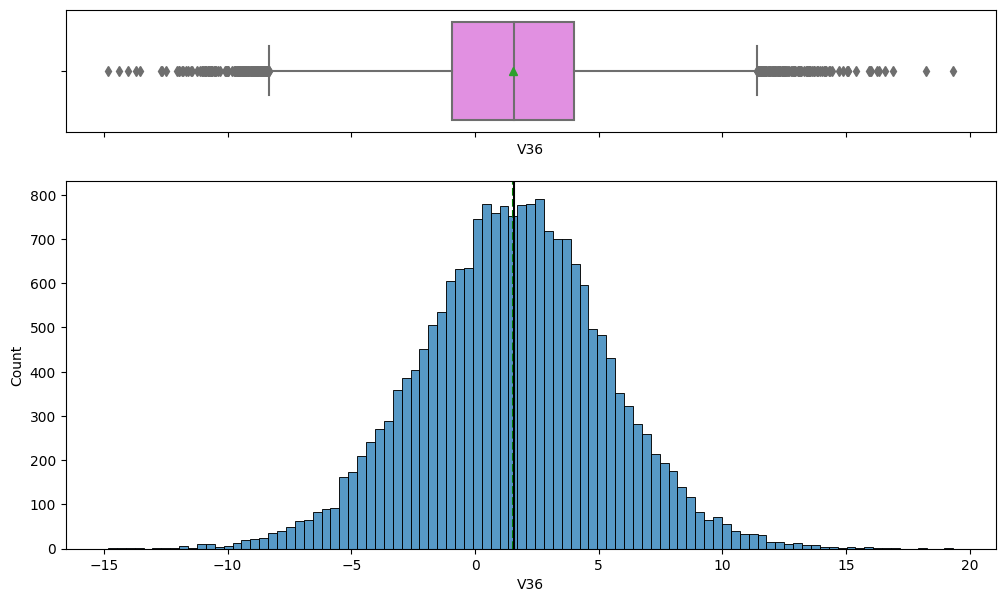

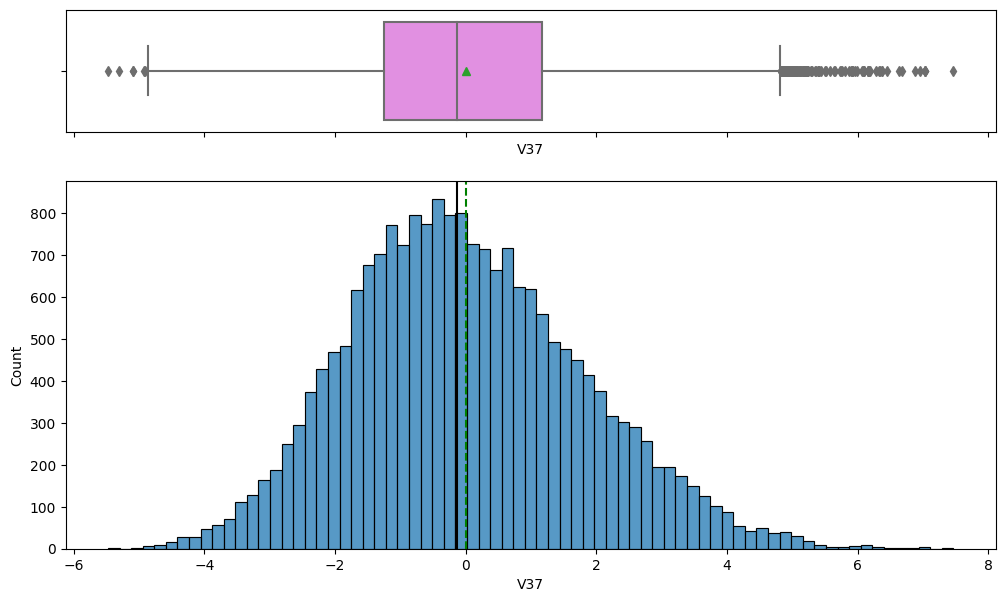

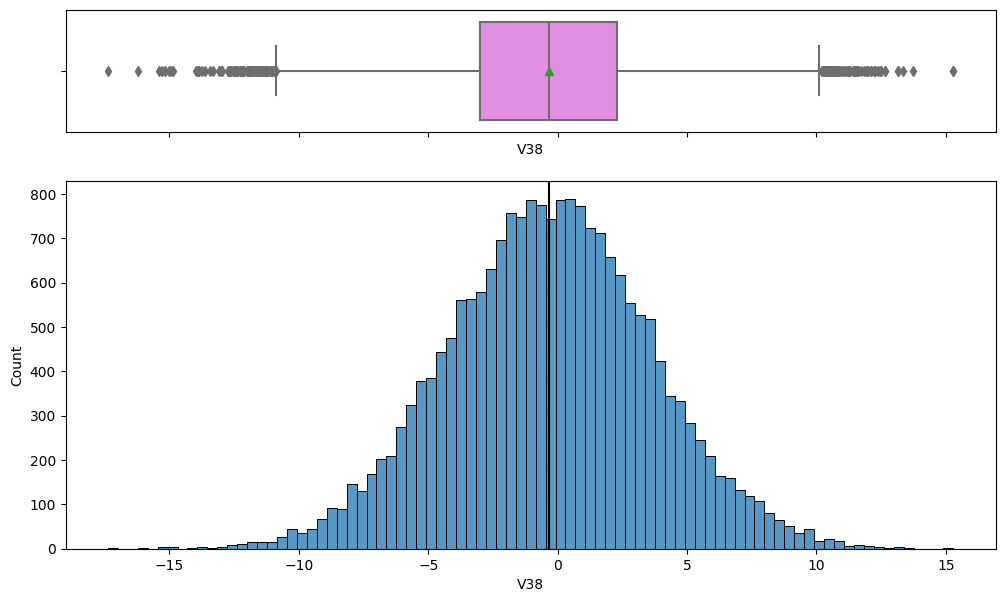

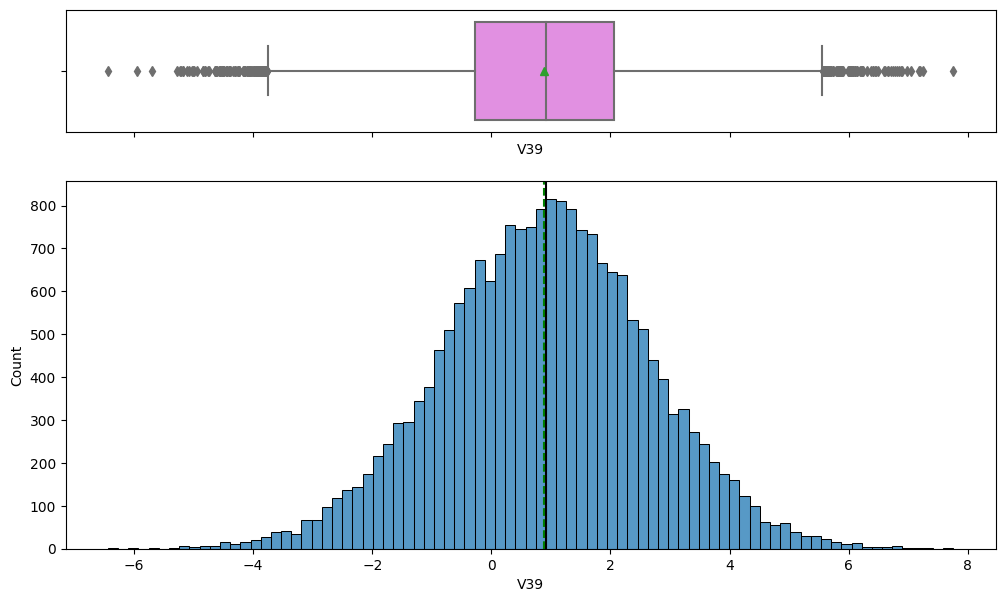

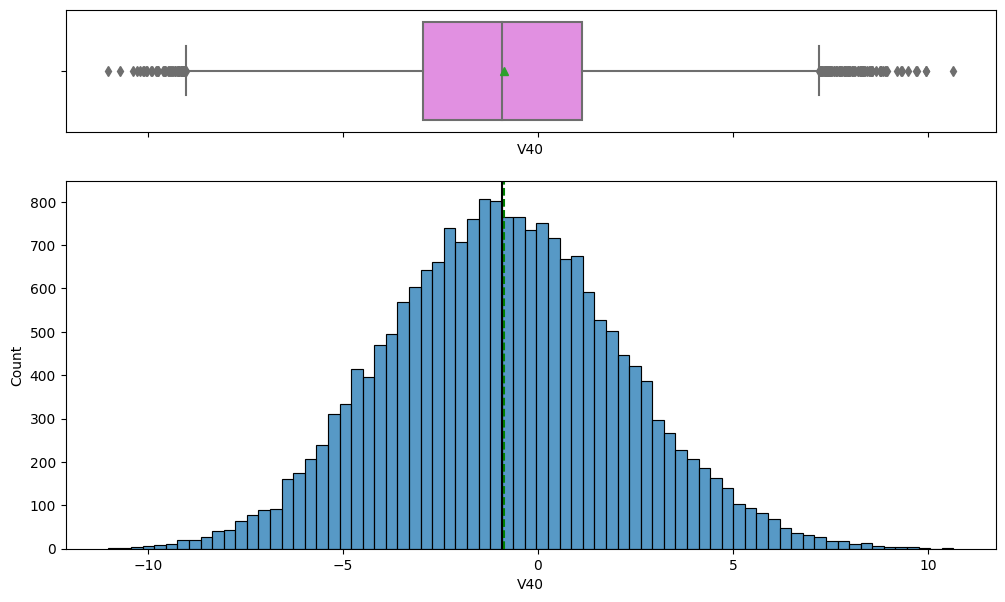

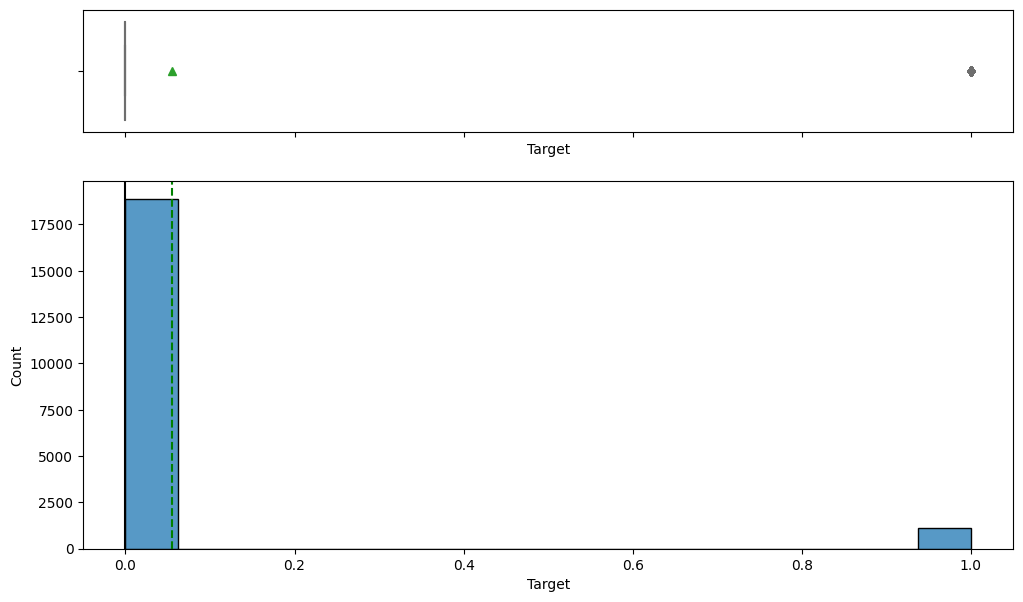

In [10]:
for feature in df_train.columns:
    histogram_boxplot(df_train, feature, figsize=(12, 7), kde=False, bins=None) ## Please change the dataframe name as you define while reading the data

In [11]:
df_train['Target'].sum()

1110

The training dataset is skewed with only 5.55% of the observations having failure recorded.

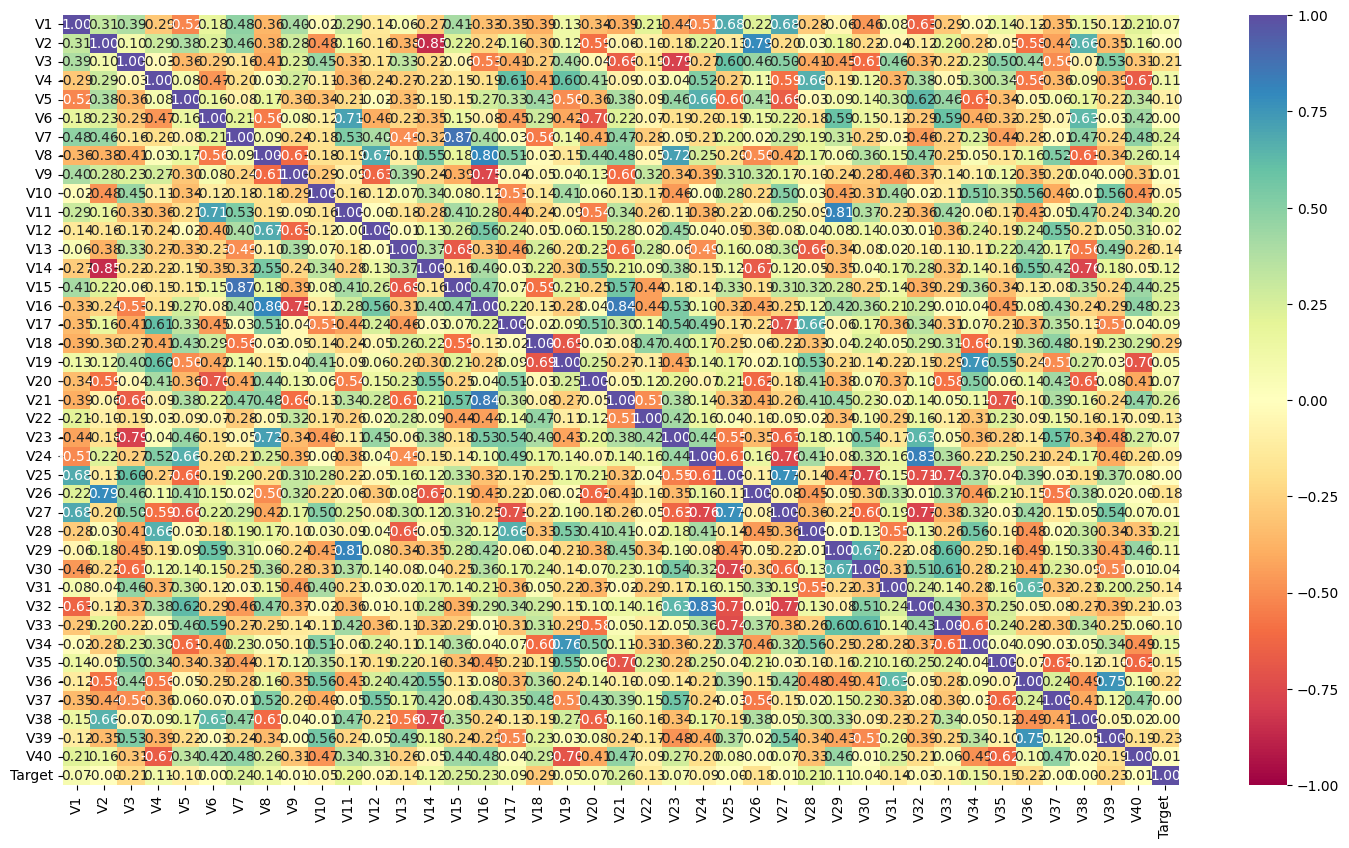

In [12]:
plt.figure(figsize=(18, 10))
sns.heatmap(df_train.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

## Data Pre-processing

In [13]:
imputer = SimpleImputer(strategy="median")

In [14]:
data1 = df_train.copy()
data2 = df_test.copy()

In [15]:
# Separating target variable and other variables
X = data1.drop(columns="Target")
X = pd.get_dummies(X)

Y = data1["Target"]

X_test = data2.drop(columns="Target")
Y_test = data2["Target"]

In [16]:
# Splitting data into training, validation
X_train, X_val, y_train, y_val = train_test_split(
    X, Y, test_size=0.25, random_state=1, stratify=Y
)
print(X_train.shape, X_val.shape, X_test.shape)

(15000, 40) (5000, 40) (5000, 40)


In [17]:
# Checking that no column has missing values in train or test sets
print(X_train.isna().sum())
print("-" * 30)
print(X_val.isna().sum())
print("-" * 30)
print(X_test.isna().sum())

V1     15
V2     14
V3      0
V4      0
V5      0
V6      0
V7      0
V8      0
V9      0
V10     0
V11     0
V12     0
V13     0
V14     0
V15     0
V16     0
V17     0
V18     0
V19     0
V20     0
V21     0
V22     0
V23     0
V24     0
V25     0
V26     0
V27     0
V28     0
V29     0
V30     0
V31     0
V32     0
V33     0
V34     0
V35     0
V36     0
V37     0
V38     0
V39     0
V40     0
dtype: int64
------------------------------
V1     3
V2     4
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     5
V2     6
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0

## Missing value imputation




In [18]:
imputer = SimpleImputer(strategy="median")

In [19]:
# Fit and transform the train data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Transform the validation data
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_train.columns)

# Transform the test data
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns)

In [20]:
# Checking that no column has missing values in train or test sets
print(X_train.isna().sum())
print("-" * 30)
print(X_val.isna().sum())
print("-" * 30)
print(X_test.isna().sum())

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model. 
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [21]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1
            
        },
        index=[0],
    )

    return df_perf

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [22]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

In [23]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Model Building with original data

Sample Decision Tree model building with original data 

In [49]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic Regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic Regression: 0.4927566553639709
Bagging: 0.7210807301060529
Random forest: 0.7235192266070268
GBM: 0.7066661857008874
Adaboost: 0.6309140754635308
Xgboost: 0.8100497799581561
dtree: 0.6982829521679532

Validation Performance:

Logistic Regression: 0.4856115107913669
Bagging: 0.7302158273381295
Random forest: 0.7266187050359713
GBM: 0.7230215827338129
Adaboost: 0.6762589928057554
Xgboost: 0.8309352517985612
dtree: 0.7050359712230215


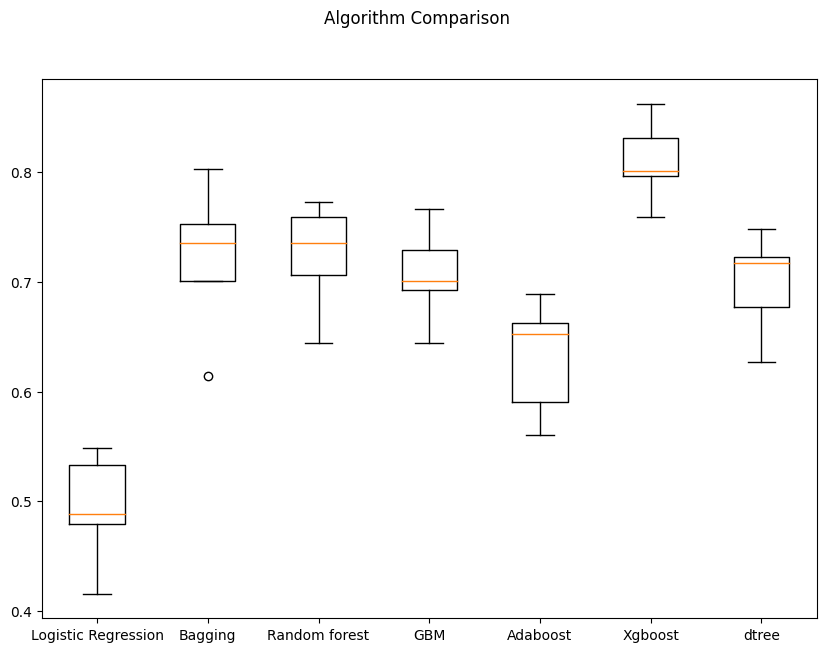

In [50]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

In [51]:
lr = LogisticRegression(random_state=1)
lr.fit(X_train, y_train)

LogisticRegression(random_state=1)

In [52]:
# Calculating different metrics on train set
log_reg_model_train_perf = model_performance_classification_sklearn(
    lr, X_train, y_train
)
print("Training performance:")
log_reg_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.967,0.495,0.843,0.624


In [53]:
# Calculating different metrics on validation set
log_reg_model_val_perf = model_performance_classification_sklearn(lr, X_val, y_val)
print("Validation performance:")
log_reg_model_val_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.966,0.486,0.844,0.616


XGboost had the highest cross validated recall followed by Random forest and Bagging. We will tune these models to see if performance imrpoves.

### Model Building with Oversampled data


Logistic Regression classifcation model

In [27]:
print("Before Oversampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Oversampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

sm = SMOTE(
    sampling_strategy=1, k_neighbors=5, random_state=1
)  # Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After Oversampling, counts of label 'Yes': {}".format(sum(y_train_over == 1)))
print("After Oversampling, counts of label 'No': {} \n".format(sum(y_train_over == 0)))


print("After Oversampling, the shape of train_X: {}".format(X_train_over.shape))
print("After Oversampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before Oversampling, counts of label 'Yes': 832
Before Oversampling, counts of label 'No': 14168 

After Oversampling, counts of label 'Yes': 14168
After Oversampling, counts of label 'No': 14168 

After Oversampling, the shape of train_X: (28336, 40)
After Oversampling, the shape of train_y: (28336,) 



In [28]:
log_reg_over = LogisticRegression(random_state=1)

# Training the basic logistic regression model with training set
log_reg_over.fit(X_train_over, y_train_over)

LogisticRegression(random_state=1)

In [29]:
# Calculating different metrics on train set
log_reg_over_train_perf = model_performance_classification_sklearn(
    log_reg_over, X_train_over, y_train_over
)
print("Training performance:")
log_reg_over_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.880,0.884,0.878,0.881


In [30]:
# Calculating different metrics on validation set
log_reg_over_val_perf = model_performance_classification_sklearn(
    log_reg_over, X_val, y_val
)
print("validation performance:")
log_reg_over_val_perf

validation performance:


,Accuracy,Recall,Precision,F1
0,0.868,0.849,0.277,0.417


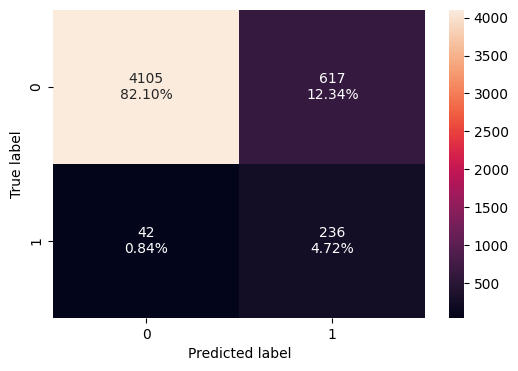

In [31]:
# creating confusion matrix
confusion_matrix_sklearn(log_reg_over, X_val, y_val)

In [32]:
scoring = "recall"
kfold = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=1
)  # Setting number of splits equal to 5
cv_result_over = cross_val_score(
    estimator=log_reg_over, X=X_train_over, y=y_train_over, scoring=scoring, cv=kfold
)
cv_result_over

array([0.87720536, 0.88280974, 0.88280974, 0.8895554 , 0.88743825])

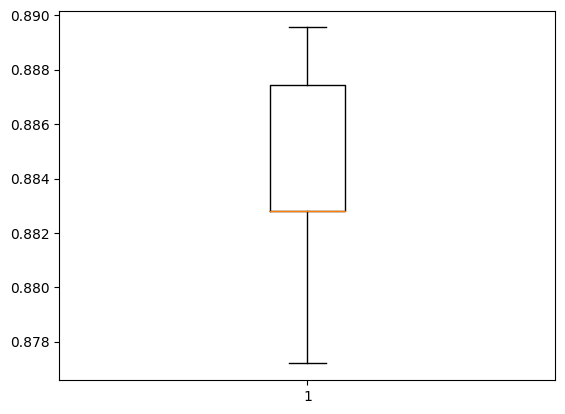

In [33]:
# Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_over)
plt.show()

Bagging Classifier Oversample model

Training performance:
   Accuracy  Recall  Precision    F1
0     0.999   0.998      1.000 0.999
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.980   0.835      0.806 0.820
Cross-validation results:
[0.97106563 0.97599718 0.97846806 0.97671136 0.97882851]


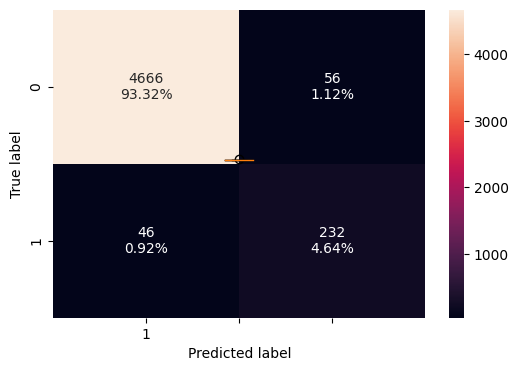

In [34]:
# Define and train BaggingClassifier
bagging_over = BaggingClassifier(random_state=1)
bagging_over.fit(X_train_over, y_train_over)

# Evaluate performance on training set
bagging_over_train_perf = model_performance_classification_sklearn(bagging_over, X_train_over, y_train_over)
print("Training performance:")
print(bagging_over_train_perf)

# Evaluate performance on validation set
bagging_over_val_perf = model_performance_classification_sklearn(bagging_over, X_val, y_val)
print("Validation performance:")
print(bagging_over_val_perf)

# Confusion matrix
confusion_matrix_sklearn(bagging_over, X_val, y_val)

# Cross-validation
cv_result_bagging_over = cross_val_score(estimator=bagging_over, X=X_train_over, y=y_train_over, scoring=scoring, cv=kfold)
print("Cross-validation results:")
print(cv_result_bagging_over)

# Boxplot of CV scores
plt.boxplot(cv_result_bagging_over)
plt.show()

RandomForest Classifier Oversampled model

Training performance:
   Accuracy  Recall  Precision    F1
0     1.000   1.000      1.000 1.000
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.988   0.849      0.937 0.891
Cross-validation results:
[0.97812279 0.98305683 0.98658666 0.98270995 0.9890614 ]


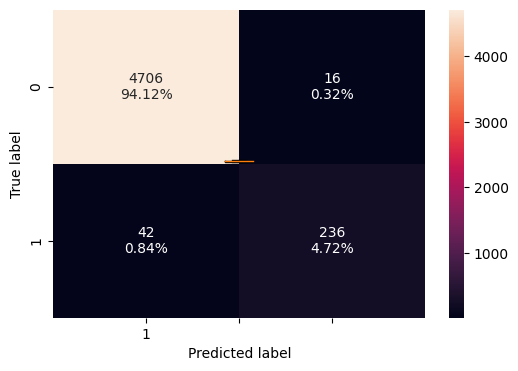

In [35]:
# Define and train RandomForestClassifier
rf_over = RandomForestClassifier(random_state=1)
rf_over.fit(X_train_over, y_train_over)

# Evaluate performance on training set
rf_over_train_perf = model_performance_classification_sklearn(rf_over, X_train_over, y_train_over)
print("Training performance:")
print(rf_over_train_perf)

# Evaluate performance on validation set
rf_over_val_perf = model_performance_classification_sklearn(rf_over, X_val, y_val)
print("Validation performance:")
print(rf_over_val_perf)

# Confusion matrix
confusion_matrix_sklearn(rf_over, X_val, y_val)

# Cross-validation
cv_result_rf_over = cross_val_score(estimator=rf_over, X=X_train_over, y=y_train_over, scoring=scoring, cv=kfold)
print("Cross-validation results:")
print(cv_result_rf_over)

# Boxplot of CV scores
plt.boxplot(cv_result_rf_over)
plt.show()

GradientBoostingClassifier Oversample model

Training performance:
   Accuracy  Recall  Precision    F1
0     0.954   0.931      0.976 0.953
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.964   0.878      0.622 0.728
Cross-validation results:
[0.92095977 0.92410872 0.9244617  0.93154552 0.92695836]


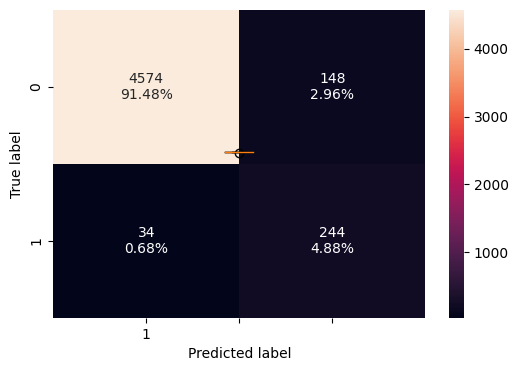

In [36]:
# Define and train GradientBoostingClassifier
gbm_over = GradientBoostingClassifier(random_state=1)
gbm_over.fit(X_train_over, y_train_over)

# Evaluate performance on training set
gbm_over_train_perf = model_performance_classification_sklearn(gbm_over, X_train_over, y_train_over)
print("Training performance:")
print(gbm_over_train_perf)

# Evaluate performance on validation set
gbm_over_val_perf = model_performance_classification_sklearn(gbm_over, X_val, y_val)
print("Validation performance:")
print(gbm_over_val_perf)

# Confusion matrix
confusion_matrix_sklearn(gbm_over, X_val, y_val)

# Cross-validation
cv_result_gbm_over = cross_val_score(estimator=gbm_over, X=X_train_over, y=y_train_over, scoring=scoring, cv=kfold)
print("Cross-validation results:")
print(cv_result_gbm_over)

# Boxplot of CV scores
plt.boxplot(cv_result_gbm_over)
plt.show()

AdaBoostClassifier Oversample model

Training performance:
   Accuracy  Recall  Precision    F1
0     0.914   0.903      0.923 0.913
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.912   0.856      0.374 0.520
Cross-validation results:
[0.88496824 0.90681257 0.89551712 0.90578687 0.8962597 ]


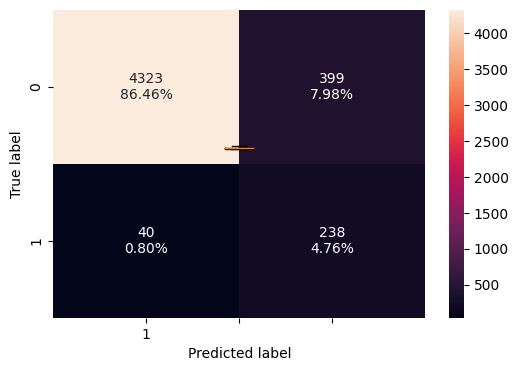

In [37]:
# Define and train AdaBoostClassifier
adaboost_over = AdaBoostClassifier(random_state=1)
adaboost_over.fit(X_train_over, y_train_over)

# Evaluate performance on training set
adaboost_over_train_perf = model_performance_classification_sklearn(adaboost_over, X_train_over, y_train_over)
print("Training performance:")
print(adaboost_over_train_perf)

# Evaluate performance on validation set
adaboost_over_val_perf = model_performance_classification_sklearn(adaboost_over, X_val, y_val)
print("Validation performance:")
print(adaboost_over_val_perf)

# Confusion matrix
confusion_matrix_sklearn(adaboost_over, X_val, y_val)

# Cross-validation
cv_result_adaboost_over = cross_val_score(estimator=adaboost_over, X=X_train_over, y=y_train_over, scoring=scoring, cv=kfold)
print("Cross-validation results:")
print(cv_result_adaboost_over)

# Boxplot of CV scores
plt.boxplot(cv_result_adaboost_over)
plt.show()

XGBClassifier Oversample model

Training performance:
   Accuracy  Recall  Precision    F1
0     1.000   1.000      1.000 1.000
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.987   0.867      0.903 0.884
Cross-validation results:
[0.98553282 0.9897635  0.9897635  0.98941426 0.99117855]


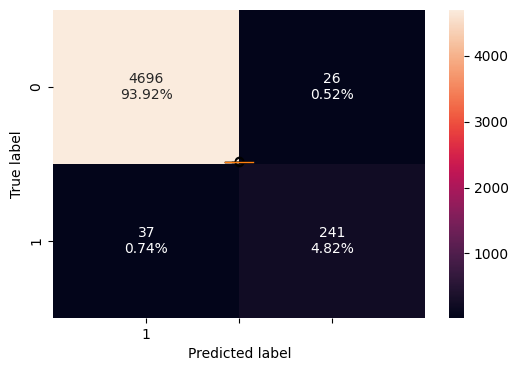

In [38]:
# Define and train XGBClassifier
xgb_over = XGBClassifier(random_state=1)
xgb_over.fit(X_train_over, y_train_over)

# Evaluate performance on training set
xgb_over_train_perf = model_performance_classification_sklearn(xgb_over, X_train_over, y_train_over)
print("Training performance:")
print(xgb_over_train_perf)

# Evaluate performance on validation set
xgb_over_val_perf = model_performance_classification_sklearn(xgb_over, X_val, y_val)
print("Validation performance:")
print(xgb_over_val_perf)

# Confusion matrix
confusion_matrix_sklearn(xgb_over, X_val, y_val)

# Cross-validation
cv_result_xgb_over = cross_val_score(estimator=xgb_over, X=X_train_over, y=y_train_over, scoring=scoring, cv=kfold)
print("Cross-validation results:")
print(cv_result_xgb_over)

# Boxplot of CV scores
plt.boxplot(cv_result_xgb_over)
plt.show()

DecisionTreeClassifier

Training performance:
   Accuracy  Recall  Precision    F1
0     1.000   1.000      1.000 1.000
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.949   0.777      0.531 0.631
Cross-validation results:
[0.96930134 0.96858454 0.97176138 0.97600565 0.97459421]


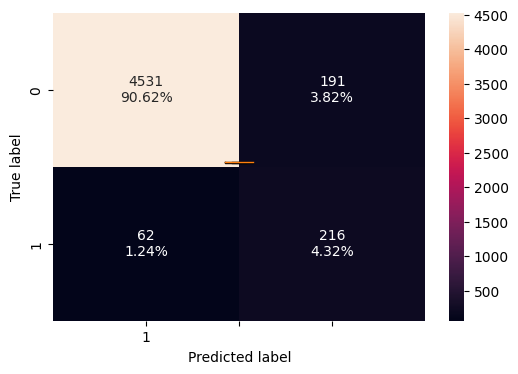

In [39]:
# Define and train DecisionTreeClassifier
dtree_over = DecisionTreeClassifier(random_state=1)
dtree_over.fit(X_train_over, y_train_over)

# Evaluate performance on training set
dtree_over_train_perf = model_performance_classification_sklearn(dtree_over, X_train_over, y_train_over)
print("Training performance:")
print(dtree_over_train_perf)

# Evaluate performance on validation set
dtree_over_val_perf = model_performance_classification_sklearn(dtree_over, X_val, y_val)
print("Validation performance:")
print(dtree_over_val_perf)

# Confusion matrix
confusion_matrix_sklearn(dtree_over, X_val, y_val)

# Cross-validation
cv_result_dtree_over = cross_val_score(estimator=dtree_over, X=X_train_over, y=y_train_over, scoring=scoring, cv=kfold)
print("Cross-validation results:")
print(cv_result_dtree_over)

# Boxplot of CV scores
plt.boxplot(cv_result_dtree_over)
plt.show()

### Model Building with Undersampled data

In [40]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [41]:
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)


print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))


print("After UnderSampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))


print("After UnderSampling, the shape of train_X: {}".format(X_train_un.shape))
print("After UnderSampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before UnderSampling, counts of label '1': 832
Before UnderSampling, counts of label '0': 14168 

After UnderSampling, counts of label '1': 832
After UnderSampling, counts of label '0': 832 

After UnderSampling, the shape of train_X: (1664, 40)
After UnderSampling, the shape of train_y: (1664,) 



In [42]:
log_reg_under = LogisticRegression(random_state=1)
log_reg_under.fit(X_train_un, y_train_un)

LogisticRegression(random_state=1)

In [43]:
# Calculating different metrics on train set
log_reg_under_train_perf = model_performance_classification_sklearn(
    log_reg_under, X_train_un, y_train_un
)
print("Training performance:")
log_reg_under_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.873,0.875,0.872,0.873


In [44]:
# Calculating different metrics on validation set
log_reg_under_val_perf = model_performance_classification_sklearn(
    log_reg_under, X_val, y_val
)
print("Validation performance:")
log_reg_under_val_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.857,0.853,0.260,0.399


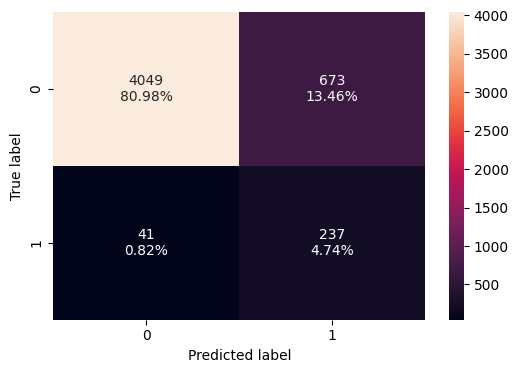

In [45]:
# creating confusion matrix
confusion_matrix_sklearn(log_reg_under, X_val, y_val)

In [46]:
scoring = "recall"
kfold = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=1
)  # Setting number of splits equal to 5
cv_result_under = cross_val_score(
    estimator=log_reg_under, X=X_train_un, y=y_train_un, scoring=scoring, cv=kfold
)
cv_result_under

array([0.86144578, 0.86746988, 0.88622754, 0.84431138, 0.90361446])

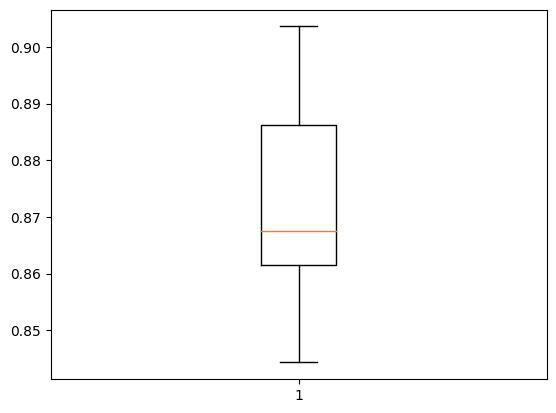

In [47]:
# Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_under)
plt.show()

In [56]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        log_reg_model_train_perf.T,
        log_reg_over_train_perf.T,
        log_reg_under_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Logistic Regression",
    "Logistic Regression with oversampled data",
    "Logistic Regression with undersampled data",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Logistic Regression,Logistic Regression with oversampled data,Logistic Regression with undersampled data
Accuracy,0.967,0.880,0.873
Recall,0.495,0.884,0.875
Precision,0.843,0.878,0.872
F1,0.624,0.881,0.873


BaggingClassifier Undersample model

Training performance:
   Accuracy  Recall  Precision    F1
0     0.990   0.983      0.998 0.990
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.928   0.871      0.428 0.574
Cross-validation results:
[0.88554217 0.86144578 0.88023952 0.83832335 0.85542169]


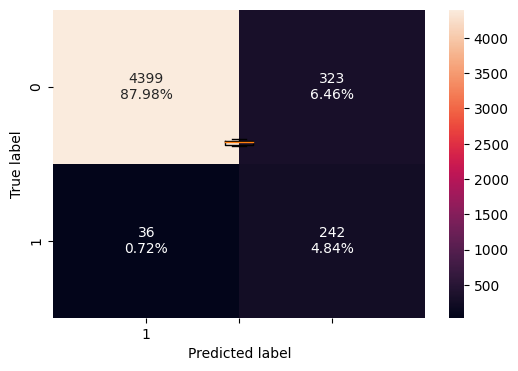

In [57]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

# Define and train BaggingClassifier
bagging_under = BaggingClassifier(random_state=1)
bagging_under.fit(X_train_un, y_train_un)

# Evaluate performance on training set
bagging_under_train_perf = model_performance_classification_sklearn(bagging_under, X_train_un, y_train_un)
print("Training performance:")
print(bagging_under_train_perf)

# Evaluate performance on validation set
bagging_under_val_perf = model_performance_classification_sklearn(bagging_under, X_val, y_val)
print("Validation performance:")
print(bagging_under_val_perf)

# Confusion matrix
confusion_matrix_sklearn(bagging_under, X_val, y_val)

# Cross-validation
cv_result_bagging_under = cross_val_score(estimator=bagging_under, X=X_train_un, y=y_train_un, scoring=scoring, cv=kfold)
print("Cross-validation results:")
print(cv_result_bagging_under)

# Boxplot of CV scores
plt.boxplot(cv_result_bagging_under)
plt.show()

RandomForestClassifier Undersample

Training performance:
   Accuracy  Recall  Precision    F1
0     1.000   1.000      1.000 1.000
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.947   0.892      0.515 0.653
Cross-validation results:
[0.92168675 0.89156627 0.91616766 0.8742515  0.91566265]


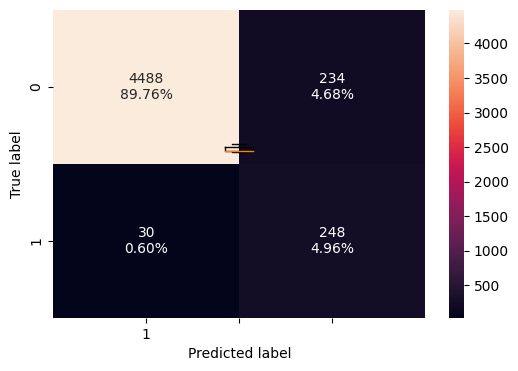

In [58]:
# Define and train RandomForestClassifier
rf_under = RandomForestClassifier(random_state=1)
rf_under.fit(X_train_un, y_train_un)

# Evaluate performance on training set
rf_under_train_perf = model_performance_classification_sklearn(rf_under, X_train_un, y_train_un)
print("Training performance:")
print(rf_under_train_perf)

# Evaluate performance on validation set
rf_under_val_perf = model_performance_classification_sklearn(rf_under, X_val, y_val)
print("Validation performance:")
print(rf_under_val_perf)

# Confusion matrix
confusion_matrix_sklearn(rf_under, X_val, y_val)

# Cross-validation
cv_result_rf_under = cross_val_score(estimator=rf_under, X=X_train_un, y=y_train_un, scoring=scoring, cv=kfold)
print("Cross-validation results:")
print(cv_result_rf_under)

# Boxplot of CV scores
plt.boxplot(cv_result_rf_under)
plt.show()

gradientBoostingClassifier Undersample

Training performance:
   Accuracy  Recall  Precision    F1
0     0.965   0.940      0.989 0.964
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.931   0.888      0.439 0.587
Cross-validation results:
[0.90963855 0.89759036 0.91017964 0.86826347 0.90361446]


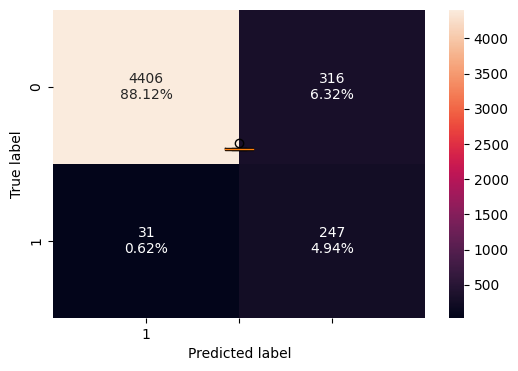

In [59]:
# Define and train GradientBoostingClassifier
gbm_under = GradientBoostingClassifier(random_state=1)
gbm_under.fit(X_train_un, y_train_un)

# Evaluate performance on training set
gbm_under_train_perf = model_performance_classification_sklearn(gbm_under, X_train_un, y_train_un)
print("Training performance:")
print(gbm_under_train_perf)

# Evaluate performance on validation set
gbm_under_val_perf = model_performance_classification_sklearn(gbm_under, X_val, y_val)
print("Validation performance:")
print(gbm_under_val_perf)

# Confusion matrix
confusion_matrix_sklearn(gbm_under, X_val, y_val)

# Cross-validation
cv_result_gbm_under = cross_val_score(estimator=gbm_under, X=X_train_un, y=y_train_un, scoring=scoring, cv=kfold)
print("Cross-validation results:")
print(cv_result_gbm_under)

# Boxplot of CV scores
plt.boxplot(cv_result_gbm_under)
plt.show()

AdaBoostClassifier undersample

Training performance:
   Accuracy  Recall  Precision    F1
0     0.922   0.905      0.938 0.921
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.877   0.849      0.292 0.435
Cross-validation results:
[0.88554217 0.86746988 0.84431138 0.86826347 0.86746988]


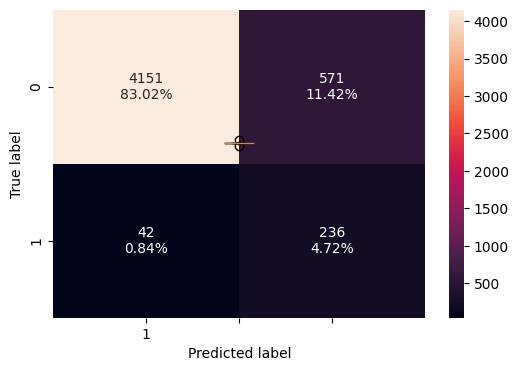

In [60]:
# Define and train AdaBoostClassifier
adaboost_under = AdaBoostClassifier(random_state=1)
adaboost_under.fit(X_train_un, y_train_un)

# Evaluate performance on training set
adaboost_under_train_perf = model_performance_classification_sklearn(adaboost_under, X_train_un, y_train_un)
print("Training performance:")
print(adaboost_under_train_perf)

# Evaluate performance on validation set
adaboost_under_val_perf = model_performance_classification_sklearn(adaboost_under, X_val, y_val)
print("Validation performance:")
print(adaboost_under_val_perf)

# Confusion matrix
confusion_matrix_sklearn(adaboost_under, X_val, y_val)

# Cross-validation
cv_result_adaboost_under = cross_val_score(estimator=adaboost_under, X=X_train_un, y=y_train_un, scoring=scoring, cv=kfold)
print("Cross-validation results:")
print(cv_result_adaboost_under)

# Boxplot of CV scores
plt.boxplot(cv_result_adaboost_under)
plt.show()

XGBClassifier Undersample

Training performance:
   Accuracy  Recall  Precision    F1
0     1.000   1.000      1.000 1.000
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.954   0.896      0.552 0.683
Cross-validation results:
[0.93373494 0.88554217 0.92215569 0.85628743 0.90963855]


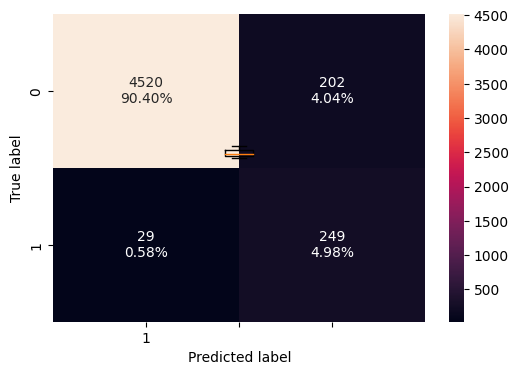

In [61]:
# Define and train XGBClassifier
xgb_under = XGBClassifier(random_state=1)
xgb_under.fit(X_train_un, y_train_un)

# Evaluate performance on training set
xgb_under_train_perf = model_performance_classification_sklearn(xgb_under, X_train_un, y_train_un)
print("Training performance:")
print(xgb_under_train_perf)

# Evaluate performance on validation set
xgb_under_val_perf = model_performance_classification_sklearn(xgb_under, X_val, y_val)
print("Validation performance:")
print(xgb_under_val_perf)

# Confusion matrix
confusion_matrix_sklearn(xgb_under, X_val, y_val)

# Cross-validation
cv_result_xgb_under = cross_val_score(estimator=xgb_under, X=X_train_un, y=y_train_un, scoring=scoring, cv=kfold)
print("Cross-validation results:")
print(cv_result_xgb_under)

# Boxplot of CV scores
plt.boxplot(cv_result_xgb_under)
plt.show()

Training performance:
   Accuracy  Recall  Precision    F1
0     1.000   1.000      1.000 1.000
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.831   0.842      0.226 0.356
Cross-validation results:
[0.86746988 0.8253012  0.8742515  0.8502994  0.89156627]


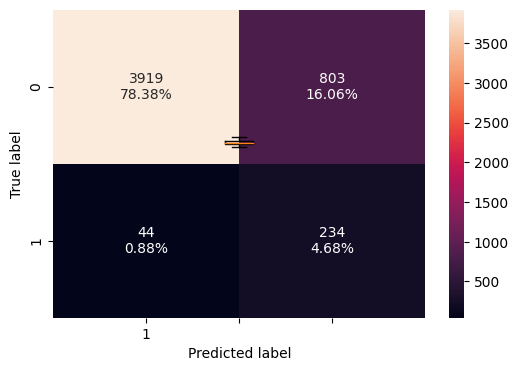

In [62]:
# Define and train DecisionTreeClassifier
dtree_under = DecisionTreeClassifier(random_state=1)
dtree_under.fit(X_train_un, y_train_un)

# Evaluate performance on training set
dtree_under_train_perf = model_performance_classification_sklearn(dtree_under, X_train_un, y_train_un)
print("Training performance:")
print(dtree_under_train_perf)

# Evaluate performance on validation set
dtree_under_val_perf = model_performance_classification_sklearn(dtree_under, X_val, y_val)
print("Validation performance:")
print(dtree_under_val_perf)

# Confusion matrix
confusion_matrix_sklearn(dtree_under, X_val, y_val)

# Cross-validation
cv_result_dtree_under = cross_val_score(estimator=dtree_under, X=X_train_un, y=y_train_un, scoring=scoring, cv=kfold)
print("Cross-validation results:")
print(cv_result_dtree_under)

# Boxplot of CV scores
plt.boxplot(cv_result_dtree_under)
plt.show()

Based on the performances of all the models, the best 3 that will be used are the GradientBoostingClassifier (Oversample), GradientBoostingClassifier (Undersample), and AdaBoostClassifier (Oversample) due to their high recall and F1 scores. These have strong performances in correctly identifying positive failure cases while maintaining a balance between precision and recall.

## HyperparameterTuning 

### Sample Parameter Grids

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7], 
    "max_features":[0.5,0.7]
}

- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

- For Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1], 
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

- For Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6), 
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- For XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

### Sample tuning AdaBoost Classifier with Oversample data

In [65]:
# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [100, 150, 200], "learning_rate": [0.2, 0.05]}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2} with CV score=0.9024565304415821:


In [68]:
# Creating new pipeline with best parameters
tuned_adaboost_over = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.2,
)

tuned_adaboost_over.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.2, n_estimators=200)

In [69]:
adaboost_grid_train = model_performance_classification_sklearn(
    tuned_adaboost_over, X_train, y_train
)
adaboost_grid_train

,Accuracy,Recall,Precision,F1
0,0.976,0.588,0.974,0.733


In [71]:
adaboost_grid_val = model_performance_classification_sklearn(tuned_adaboost_over, X_val, y_val)
adaboost_grid_val

,Accuracy,Recall,Precision,F1
0,0.974,0.586,0.926,0.718


### Tuning of GradientBoostingClassifier with Oversampled data

In [66]:
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7], "max_features":[0.5,0.7] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 1} with CV score=0.972756012725313:


In [72]:
# Creating new pipeline with best parameters
tuned_gbc_over = GradientBoostingClassifier(
    subsample=0.7,
    learning_rate=1,
    n_estimators=125,
)

tuned_gbc_over.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1, n_estimators=125, subsample=0.7)

In [82]:
gbc_grid_train = model_performance_classification_sklearn(
    tuned_gbc_over, X_train, y_train
)
gbc_grid_train

,Accuracy,Recall,Precision,F1
0,0.985,0.784,0.935,0.853


In [83]:
gbc_over_grid_val = model_performance_classification_sklearn(tuned_gbc_over, X_val, y_val)
gbc_over_grid_val

,Accuracy,Recall,Precision,F1
0,0.975,0.691,0.831,0.754


### Sample tuning GradientBoostingClassifer with undersampled data

In [84]:
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7], "max_features":[0.5,0.7] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 0.2} with CV score=0.9002164346006782:


In [85]:
# Creating new pipeline with best parameters
tuned_gbc_un = GradientBoostingClassifier(
    subsample=0.7,
    learning_rate=0.2,
    n_estimators=125,
    max_features=0.5
)

tuned_gbc_un.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, subsample=0.7)

In [86]:
gbc_grid_train_un = model_performance_classification_sklearn(
    tuned_gbc_un, X_train, y_train
)
gbc_grid_train_un

,Accuracy,Recall,Precision,F1
0,0.993,0.894,0.987,0.938


In [87]:
gbc_grid_val_un = model_performance_classification_sklearn(tuned_gbc_un, X_val, y_val)
gbc_grid_val_un

,Accuracy,Recall,Precision,F1
0,0.983,0.784,0.901,0.838


## Model performance comparison and choosing the final model

In [89]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        adaboost_grid_train.T,
        adaboost_under_train_perf.T,
        gbc_grid_train.T,
        gbm_over_train_perf.T,
        gbc_grid_train_un.T,
        gbm_under_train_perf.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Oversampled AdaBoost Tuned with Grid search",
    "Oversampled AdaBoost Tuned with Random search",
    "Oversampled Gradient Boosting Tuned with Grid search",
    "Oversampled Gradient Boosting Tuned with Random search",
    "Undersampled Gradient Boosting with grid search",
    "Undersampled Gradient Boosting with random search",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Oversampled AdaBoost Tuned with Grid search,Oversampled AdaBoost Tuned with Random search,Oversampled Gradient Boosting Tuned with Grid search,Oversampled Gradient Boosting Tuned with Random search,Undersampled Gradient Boosting with grid search,Undersampled Gradient Boosting with random search
Accuracy,0.976,0.922,0.985,0.954,0.993,0.965
Recall,0.588,0.905,0.784,0.931,0.894,0.940
Precision,0.974,0.938,0.935,0.976,0.987,0.989
F1,0.733,0.921,0.853,0.953,0.938,0.964


In [90]:
# Validation performance comparison

models_val_comp_df = pd.concat(
    [
        adaboost_grid_val.T,
        adaboost_under_val_perf.T,
        gbc_over_grid_val.T,
        gbm_over_val_perf.T,
        gbc_grid_val_un.T,
        gbm_under_val_perf.T
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "Oversampled AdaBoost Tuned with Grid search",
    "Oversampled AdaBoost Tuned with Random search",
    "Oversampled Gradient Boosting Tuned with Grid search",
    "Oversampled Gradient Boosting Tuned with Random search",
    "Undersampled Gradient Boosting with grid search",
    "Undersampled Gradient Boosting with random search",
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Oversampled AdaBoost Tuned with Grid search,Oversampled AdaBoost Tuned with Random search,Oversampled Gradient Boosting Tuned with Grid search,Oversampled Gradient Boosting Tuned with Random search,Undersampled Gradient Boosting with grid search,Undersampled Gradient Boosting with random search
Accuracy,0.974,0.877,0.975,0.964,0.983,0.931
Recall,0.586,0.849,0.691,0.878,0.784,0.888
Precision,0.926,0.292,0.831,0.622,0.901,0.439
F1,0.718,0.435,0.754,0.728,0.838,0.587


Undersampled Gradient Boosting with grid search appears to be the best performing on the validation set, due to having the highest F1 score.

### Test set final performance

In [92]:
# Calculating different metrics on the test set
gbm_grid_test = model_performance_classification_sklearn(tuned_gbc_un, X_test, Y_test)
print("Test performance:")
gbm_grid_test

Test performance:


,Accuracy,Recall,Precision,F1
0,0.980,0.723,0.895,0.800


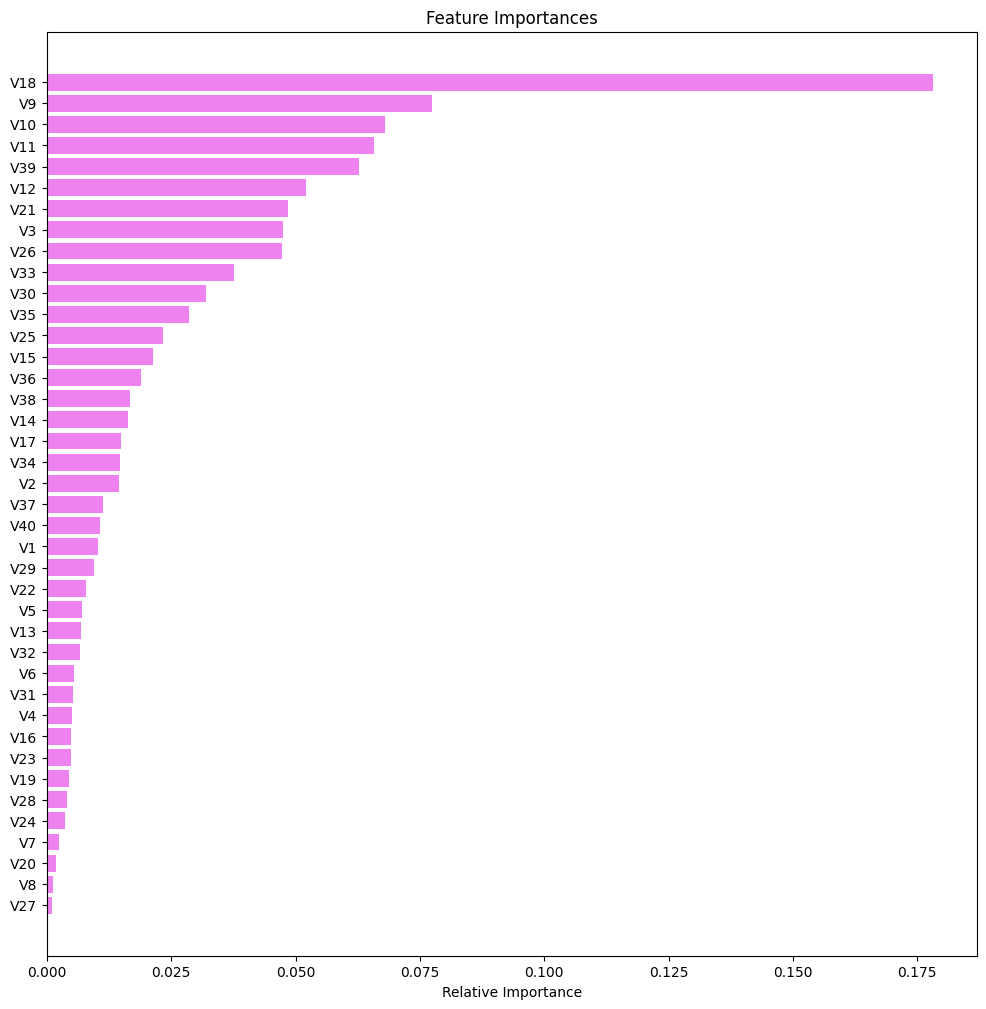

In [93]:
feature_names = X.columns
importances = tuned_gbc_un.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

V18 is the most important sensor for this model. This model's performance on the test data is generalized.

## Pipelines to build the final model


In [126]:
# creating a list of numerical variables
numerical_features = [
    "V1",
    "V2",
    "V3",
    "V4",
    "V5",
    "V6",
    "V7",
    "V8",
    "V9",
    "V10",
    "V11",
    "V12",
    "V13",
    "V14",
    "V15",
    "V16",
    "V17",
    "V18",
    "V19",
    "V20",
    "V21",
    "V22",
    "V23",
    "V24",
    "V25",
    "V26",
    "V27",
    "V28",
    "V29",
    "V30",
    "V31",
    "V32",
    "V33",
    "V34",
    "V35",
    "V36",
    "V37",
    "V38",
    "V39",
    "V40",
    "Target",
]

# creating a transformer for numerical variables, which will apply simple imputer on the numerical variables
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])

# creating a transformer for categorical variables, which will first apply simple imputer and 
#then do one hot encoding for categorical variables
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)
# handle_unknown = "ignore", allows model to handle any unknown category in the test data

# combining categorical transformer and numerical transformer using a column transformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
    ],
    remainder="passthrough",
)
# remainder = "passthrough" has been used, it will allow variables that are present in original data 
# but not in "numerical_columns" and "categorical_columns" to pass through the column transformer without any changes

# Business Insights and Conclusions

Based on the prediction model created, operational efficiency can be improved by identifying failing machinery without having to spend the money on inspections and instead utilizing sensors and automation. 

The model should be looked into further to minimize the occurnce of false negatives as to reudce the risk of unexpected downtime and associated costs.

Quantifying potential savings accomplished with the model in addressing failing machinery should be done to highlight the effectiveness of the project.
